## Conexión de Python con DBeaver y algunos ejemplos prácticos utilizando la biblioteca *SQLAlchemy* y *pandas*.

###  Primero, instalamos las bibliotecas necesarias

In [1]:
!pip install sqlalchemy
!pip install pandas
!pip install psycopg2-binary  # Para PostgreSQL
!pip install pymysql  # Para MySQL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.0 MB/s eta 0:00:00


In [2]:
!pip install sqlalchemy

In [3]:
!pip install psycopg2-binary  # Para PostgreSQL

In [4]:
!pip install pymysql  # Para MySQL

In [5]:
import requests
import sqlite3
from sqlalchemy import create_engine
from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter

### Ejemplo básico de conexión

In [6]:
# Conexión a diferentes tipos de bases de datos
# Reemplaza los valores entre <> con tus datos de conexión

# Para PostgreSQL
#engine_postgres = create_engine('postgresql://<usuario>:<contraseña>@<host>:<puerto>/<base_de_datos>')

# Para MySQL
#engine_mysql = create_engine('mysql+pymysql://<usuario>:<contraseña>@<host>:<puerto>/<base_de_datos>')

# Para SQLite (el que viene por defecto en DBeaver con Chinook)
#engine_sqlite = create_engine('sqlite:///ruta/a/tu/archivo.db')

In [7]:
# 1. Descargar el archivo
url = 'https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite'
response = requests.get(url)

# 2. Guardar el archivo localmente
file_name = 'chinook.db'
with open(file_name, 'wb') as file:
    file.write(response.content)

# 3. Crear la conexión con SQLAlchemy
engine = create_engine(f'sqlite:///{file_name}')

# 4. Verificar las tablas disponibles
try:
    # Consulta para ver las tablas
    query_tables = """
    SELECT name FROM sqlite_master 
    WHERE type='table' AND name NOT LIKE 'sqlite_%';
    """
    df_tables = pd.read_sql(query_tables, engine)
    print("Tablas disponibles en la base de datos:")
    print(df_tables)

    # Consulta de ejemplo a la tabla Artist
    query = "SELECT * FROM Artist LIMIT 5"
    df = pd.read_sql(query, engine)
    print("\nPrimeros 5 registros de la tabla Artist:")
    print(df)

except Exception as e:
    print("Error:", e)

Tablas disponibles en la base de datos:
             name
0           Album
1          Artist
2        Customer
3        Employee
4           Genre
5         Invoice
6     InvoiceLine
7       MediaType
8        Playlist
9   PlaylistTrack
10          Track

Primeros 5 registros de la tabla Artist:
   ArtistId               Name
0         1              AC/DC
1         2             Accept
2         3          Aerosmith
3         4  Alanis Morissette
4         5    Alice In Chains


## 1. Query Dinámica Análisis de Ventas

In [8]:
def analizar_ventas(engine, year=None, country=None, min_total=None):
    """
    Realiza un análisis completo de ventas aplicando los filtros especificados.

    Parámetros:
        engine: Conexión a la base de datos.
        year (str): Año para filtrar las ventas (opcional).
        country (str): País para filtrar las ventas (opcional).
        min_total (float): Monto mínimo para filtrar las ventas (opcional).

    Retorna:
        DataFrame con los datos filtrados.
    """

    # Construir la query con los filtros aplicados
    query = """
    SELECT 
        strftime('%Y-%m', InvoiceDate) AS Mes,             -- Mes del año en formato YYYY-MM
        BillingCountry AS Pais,                            -- País asociado a la factura
        COUNT(InvoiceId) AS Num_Transacciones,             -- Número total de transacciones
        SUM(Total) AS Total_Ventas,                        -- Suma total de las ventas
        AVG(Total) AS Promedio_Ventas                      -- Promedio de las ventas
    FROM Invoice                                            -- Fuente de datos: tabla Invoice
    WHERE 1=1                                              -- Condición inicial (siempre verdadera)
    """
    if year:
        query += " AND strftime('%Y', InvoiceDate) = :year" # Filtro: solo incluir facturas del año especificado
    if country:
        query += " AND BillingCountry = :country"           # Filtro: solo incluir facturas del país especificado
    if min_total:
        query += " AND Total >= :min_total"                 # Filtro: solo incluir facturas con un monto mínimo
        
    query += " GROUP BY Mes, Pais ORDER BY Mes"             # Agrupar los resultados por mes y país

    # Ejecutar la query
    df = pd.read_sql(query, engine, params={"year": year, "country": country, "min_total": min_total})

    total_ventas = df['Total_Ventas'].sum()  
    promedio_ventas = df['Total_Ventas'].mean()  
    total_transacciones = df['Num_Transacciones'].sum()  
    top_paises = (df.groupby('Pais')['Total_Ventas']  # Agrupar las ventas por país
                  .sum()
                  .sort_values(ascending=False)  # Ordenar de mayor a menor
                  .head(5))  # Seleccionar los 5 primeros países

    # Mostrar estadísticas generales en la consola
    print("\nEstadísticas Generales:")  # Encabezado para las estadísticas
    print(f"Total de ventas: ${total_ventas:,.2f}")  # Imprimir el total de ventas con formato de moneda
    print(f"Promedio de ventas: ${promedio_ventas:,.2f}")  # Promedio de ventas con formato
    print(f"Número total de transacciones: {total_transacciones}")  # Total de transacciones
    print("\nTop 5 Países por Ventas Totales:")  # Encabezado para el top de países
    print(top_paises)  # Imprimir el DataFrame con los países destacados

    # Generar visualizaciones
    generar_visualizaciones(df)

    return df


def generar_visualizaciones(df):
    """
    Genera visualizaciones basadas en los datos filtrados.

    Parámetros:
        df: DataFrame con los datos filtrados.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(20, 12))

    # Gráfico 1: Tendencia de ventas trimestrales
    plt.subplot(2, 2, 1)
    sns.lineplot(data=df, x="Mes", y="Total_Ventas", marker='o', color="blue", linewidth=2)

    # Ajustar etiquetas del eje X para mostrar trimestralmente
    plt.xticks(
        ticks=range(0, len(df["Mes"].unique()), 3),  # Mostrar cada 3 meses
        labels=df["Mes"].unique()[::3],  # Seleccionar etiquetas cada 3 meses
        rotation=45,
        fontsize=10
    )

    plt.title("Tendencia de Ventas Trimestrales", fontsize=16, fontweight='bold')
    plt.xlabel("Mes", fontsize=12)
    plt.ylabel("Total Ventas ($)", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Gráfico 2: Total de ventas por país
    plt.subplot(2, 2, 2)
    top_countries = df.groupby("Pais")["Total_Ventas"].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")
    plt.title("Total de Ventas por País", fontsize=16, fontweight='bold')
    plt.xlabel("Total Ventas ($)", fontsize=12)
    plt.ylabel("País", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Gráfico 3: Correlación entre número y total de ventas
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=df, x="Num_Transacciones", y="Total_Ventas", alpha=0.7, color="green", s=100)
    plt.title("Correlación: Número de Transacciones vs Total Ventas", fontsize=16, fontweight='bold')
    plt.xlabel("Número de Transacciones", fontsize=12)
    plt.ylabel("Total Ventas ($)", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Gráfico 4: Distribución de ventas
    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x="Total_Ventas", bins=20, kde=True, color='purple', edgecolor='black', alpha=0.7)
    plt.title("Distribución del Total de Ventas", fontsize=16, fontweight='bold')
    plt.xlabel("Total Ventas ($)", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()


**Explicación del Código por Etapas**

1. Función analizar_ventas
Esta función tiene como objetivo principal realizar una consulta SQL dinámica para obtener datos relevantes de ventas, calcular estadísticas y generar visualizaciones. A continuación, se explican los pasos dentro de esta función:

**Construcción de la consulta SQL:**

* Se seleccionan campos clave como el mes (strftime('%Y-%m', InvoiceDate)), país, número de transacciones, suma y promedio de ventas.

* La fecha se transforma en formato YYYY-MM para agrupar las ventas por mes, facilitando el análisis temporal.
  
* Se emplea COUNT, SUM y AVG para calcular métricas agregadas esenciales como número total de transacciones, suma total de ventas y promedio de ventas, respectivamente.

* La cláusula WHERE 1=1 se utiliza como base para añadir filtros de forma dinámica sin necesidad de reescribir toda la consulta.

**Incorporación de filtros dinámicos:**

Filtros opcionales permiten personalizar el análisis:

* Año (year): Restringe los datos a facturas emitidas en un año específico.

* País (country): Filtra las ventas por país.

*   Monto mínimo (min_total): Excluye ventas menores a un monto especificado.

**Agrupación y ordenación:**

* Los datos se agrupan por mes y país (GROUP BY) para calcular métricas agregadas y se ordenan cronológicamente (ORDER BY Mes).

**Ejecución de la consulta:**

* La consulta se ejecuta mediante pd.read_sql, que devuelve un DataFrame con los resultados. Esto permite trabajar fácilmente con los datos en Python.

**Cálculo de estadísticas generales:**

* Se calculan indicadores globales para ofrecer una visión general:

    * Total de ventas: Suma de todas las ventas en el período analizado.
    
    * Promedio de ventas: Promedio del total de ventas por agrupación.
    
    * Total de transacciones: Número total de transacciones procesadas.

    * Top 5 países: Países con mayores ventas, identificados mediante la suma de ventas totales.

**Visualización de los datos:** 

* Se llama a la función generar_visualizaciones para producir gráficos que representen los datos filtrados y procesados.

**2. Función generar_visualizaciones**

Esta función genera gráficos para visualizar las tendencias, patrones y relaciones en los datos de ventas. A continuación, se describen los pasos y la lógica de cada gráfico:

**Configuración inicial:**

* Se define el tamaño del lienzo (plt.figure(figsize=(20, 12)) para garantizar que los gráficos sean claros y fáciles de interpretar.

**Gráfico 1: Tendencia de ventas trimestrales**

* Muestra la evolución de las ventas totales a lo largo del tiempo, agrupadas por mes.

* El eje X se ajusta para mostrar solo etiquetas trimestrales (cada 3 meses) para mejorar la legibilidad y evitar la saturación.

* Se utiliza una línea con marcadores (sns.lineplot) para destacar los puntos clave de la tendencia.

**Gráfico 2: Total de ventas por país**

* Representa los países con mayores ventas totales utilizando un gráfico de barras.

* Los 10 principales países se seleccionan mediante una agrupación por país y se ordenan por ventas totales.

* Esto permite identificar cuáles son los mercados más importantes en términos de ingresos.

**Gráfico 3: Correlación entre número de transacciones y ventas totales**

* Este gráfico de dispersión muestra la relación entre la cantidad de transacciones realizadas y el total de ventas.

* Ayuda a determinar si existe una correlación positiva entre estas dos variables.

**Gráfico 4: Distribución del total de ventas** 

* Se utiliza un histograma con densidad (sns.histplot) para observar cómo se distribuyen los valores de ventas totales.

* Permite identificar la concentración de ventas en diferentes rangos de montos.

**Ajustes finales:**

* Se añaden títulos, etiquetas y cuadrículas para mejorar la claridad y profesionalismo de los gráficos.

* El método plt.tight_layout() se emplea para evitar que los gráficos se superpongan.

**Conclusión**

El código está estructurado para realizar un análisis detallado de ventas de manera flexible y eficiente. Cada paso tiene como objetivo maximizar la utilidad de los datos y facilitar su interpretación mediante estadísticas clave y visualizaciones claras. Esto permite a los usuarios obtener tanto una visión general como un análisis detallado de los datos de ventas.

Reporte general de ventas:

Estadísticas Generales:
Total de ventas: $2,328.60
Promedio de ventas: $7.30
Número total de transacciones: 412

Top 5 Países por Ventas Totales:
Pais
USA        523.06
Canada     303.96
France     195.10
Brazil     190.10
Germany    156.48
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


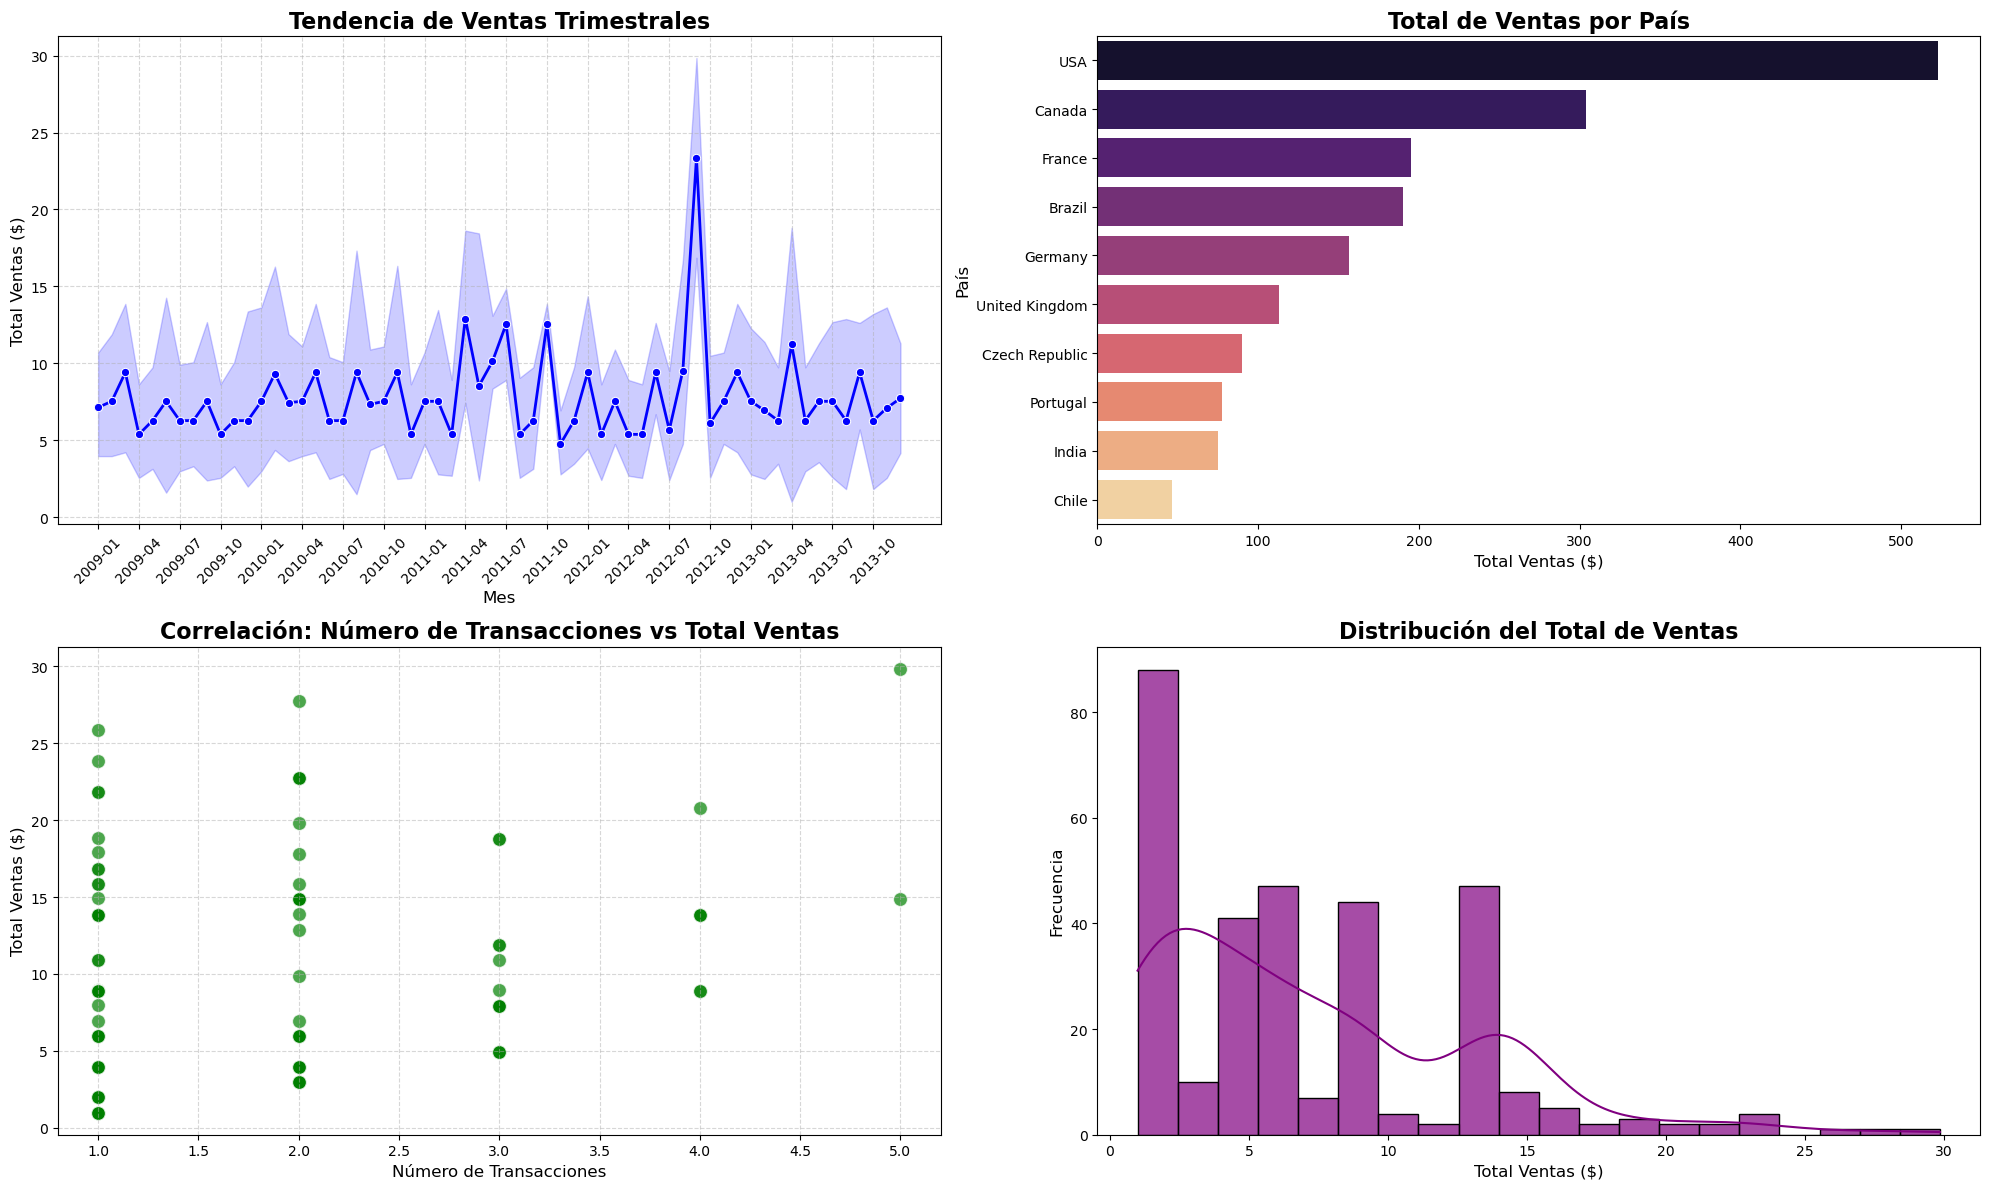


Reporte de ventas del año 2011:

Estadísticas Generales:
Total de ventas: $469.58
Promedio de ventas: $7.70
Número total de transacciones: 83

Top 5 Países por Ventas Totales:
Pais
USA        103.01
Canada      55.44
Germany     48.57
France      42.61
Ireland     32.75
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


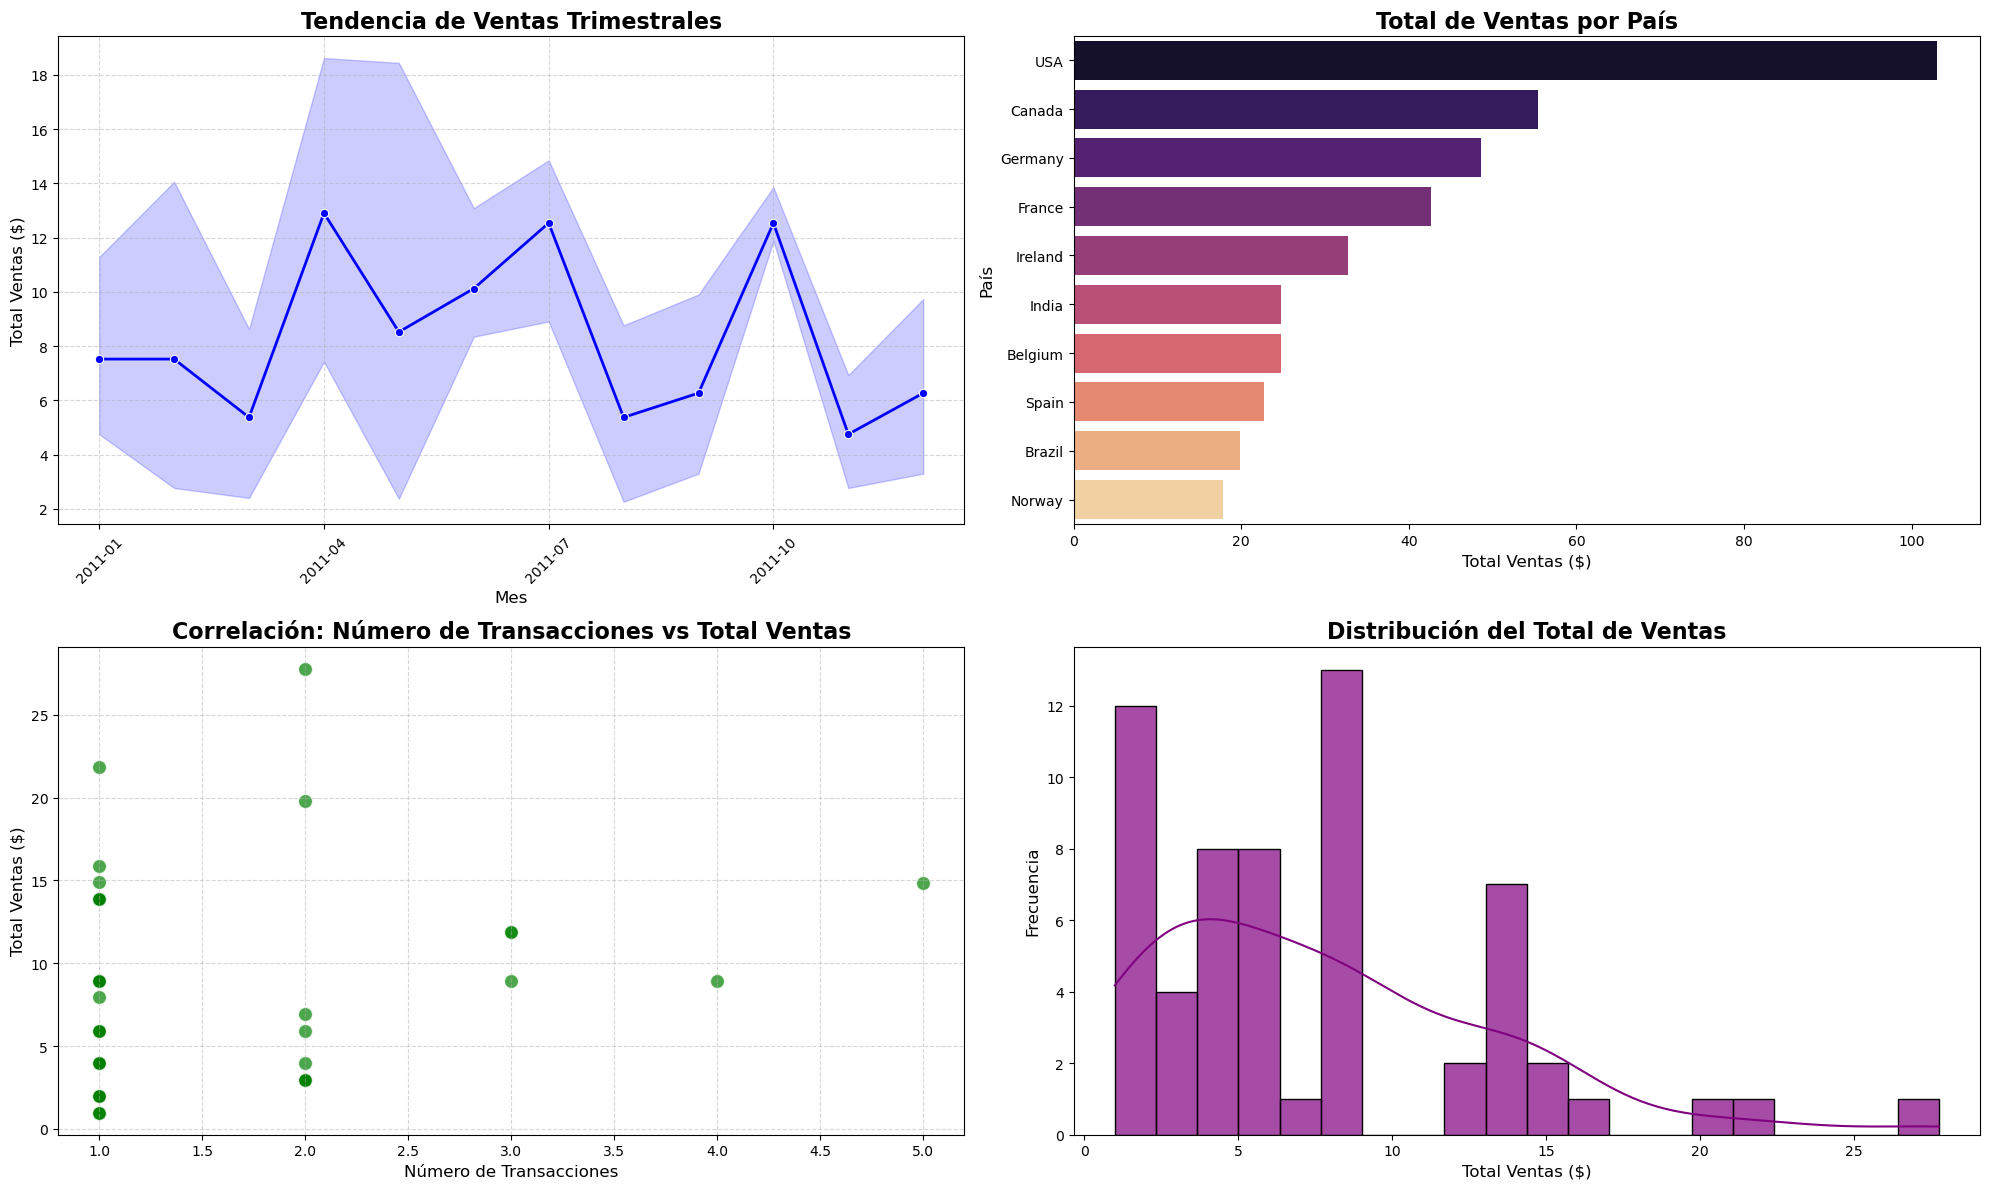


Reporte de ventas para USA con monto mínimo de $10:

Estadísticas Generales:
Total de ventas: $220.03
Promedio de ventas: $14.67
Número total de transacciones: 15

Top 5 Países por Ventas Totales:
Pais
USA    220.03
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


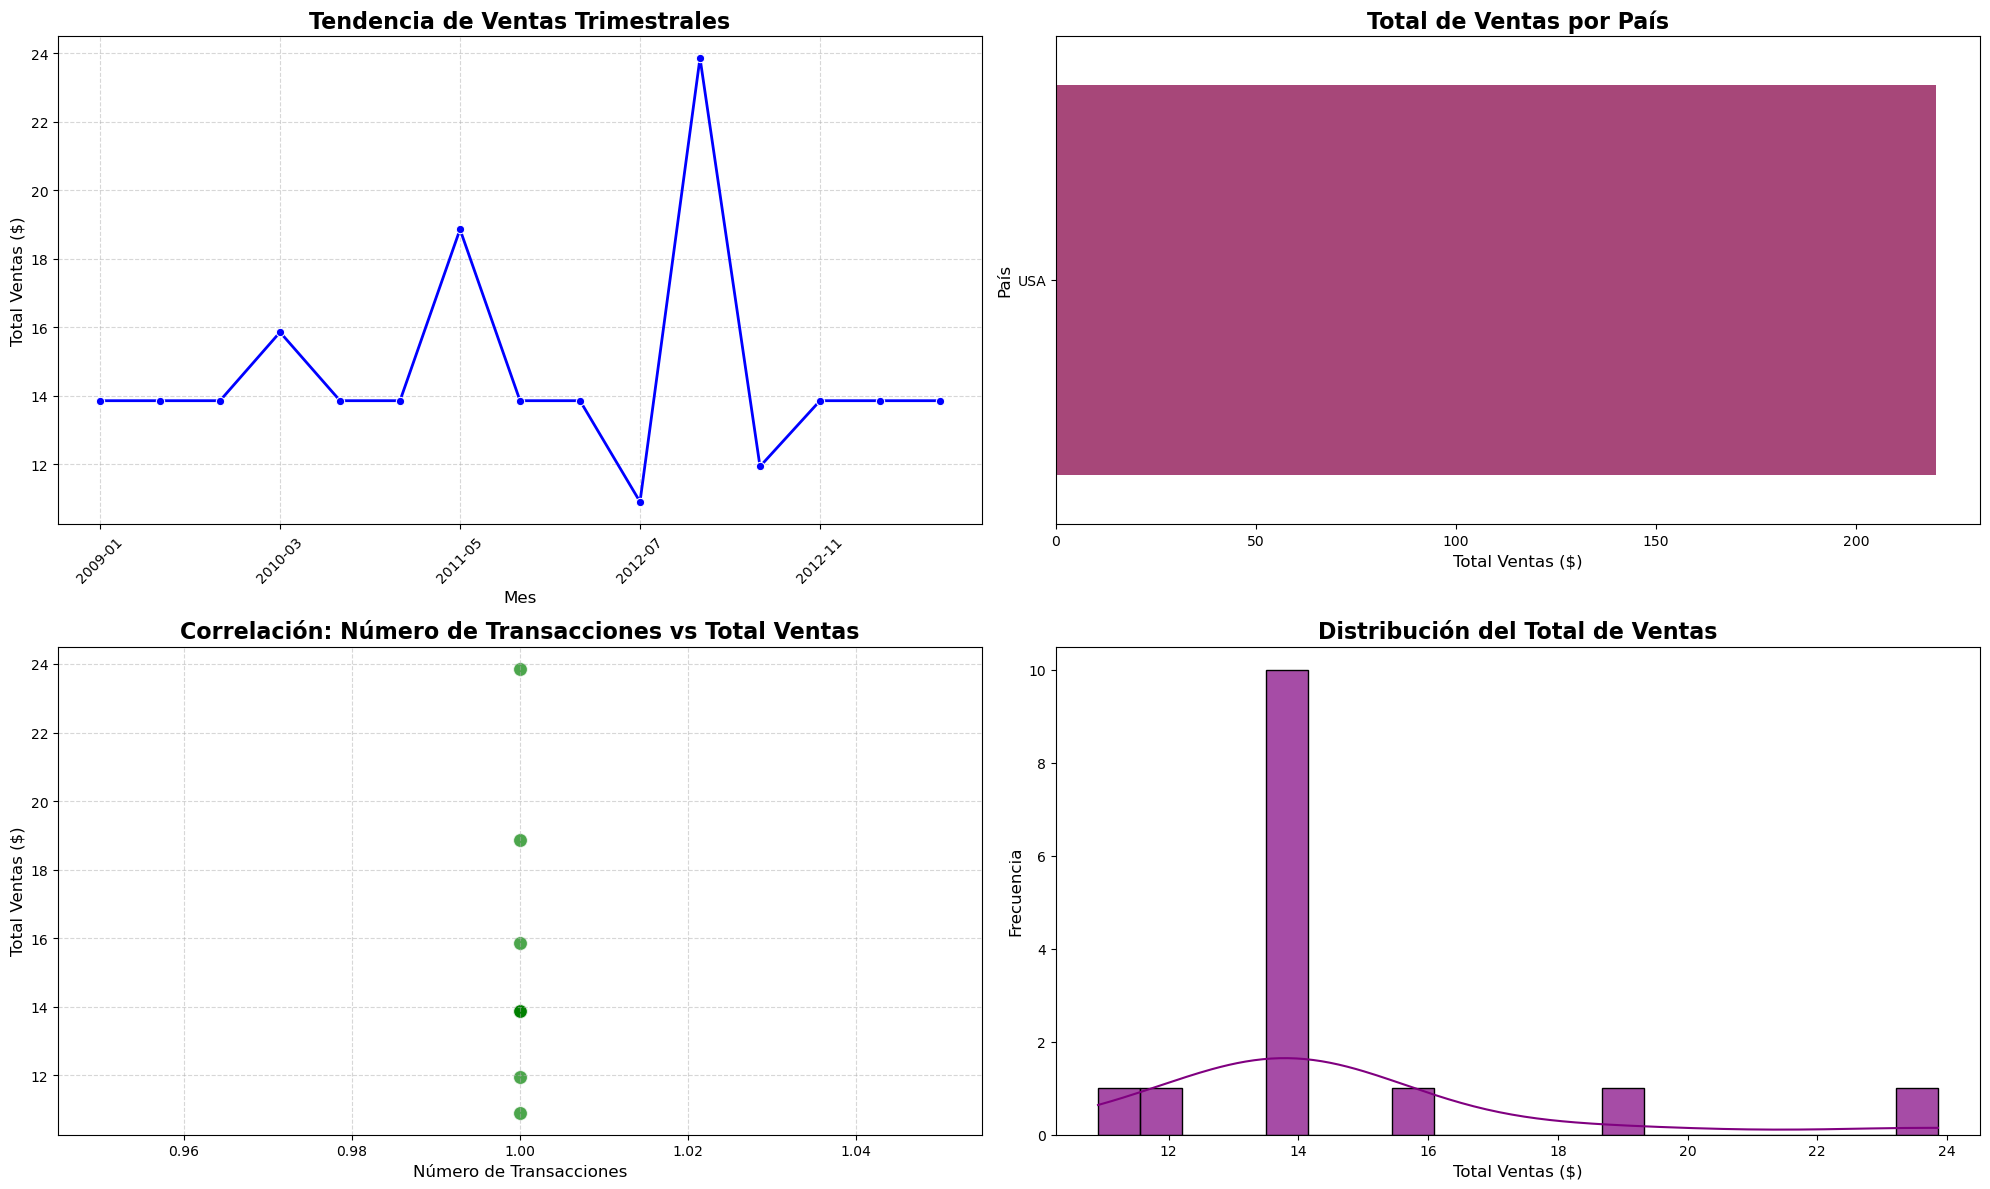


Reporte de ventas del año 2011 para USA con monto mínimo de $10:

Estadísticas Generales:
Total de ventas: $46.58
Promedio de ventas: $15.53
Número total de transacciones: 3

Top 5 Países por Ventas Totales:
Pais
USA    46.58
Name: Total_Ventas, dtype: float64


/tmp/ipykernel_1135/1888290294.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


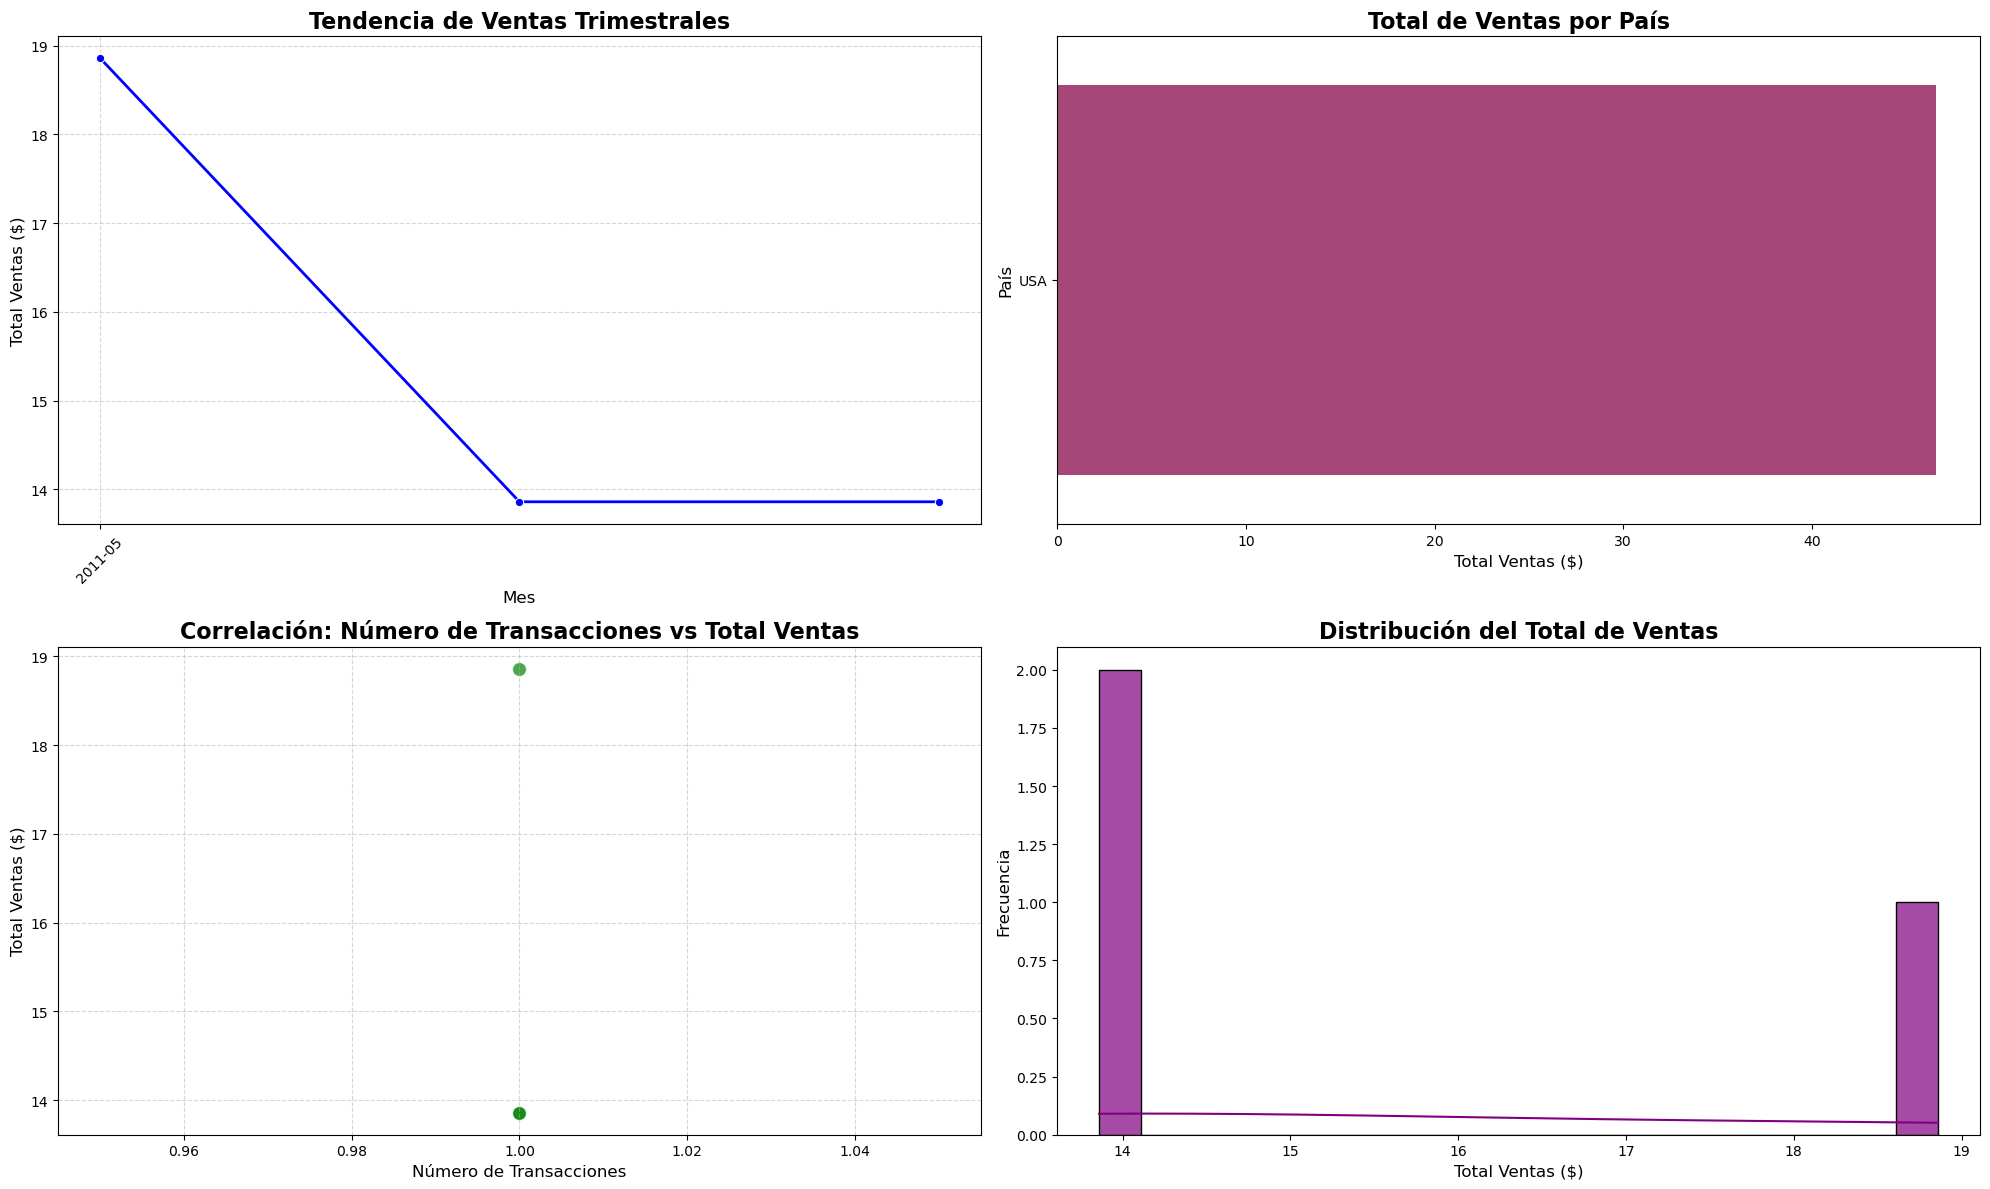

In [9]:
if __name__ == "__main__":
    #1. Análisis general de ventas
    print("Reporte general de ventas:")
    df_general = analizar_ventas(engine)
    
    #2. Análisis de ventas para el año 2011
    print("\nReporte de ventas del año 2011:")
    df_2011 = analizar_ventas(engine, year="2011")
    
    #3. Análisis de ventas para USA con monto mínimo de $10
    print("\nReporte de ventas para USA con monto mínimo de $10:")
    df_usa = analizar_ventas(engine, country="USA", min_total=10)

    #4. Análisis de ventas para 2011 en USA con monto mínimo de $10
    print("\nReporte de ventas del año 2011 para USA con monto mínimo de $10:")
    df_2011_usa = analizar_ventas(engine, year="2011", country="USA", min_total=10)

## 2. Query Dinámica Búsqueda de Canciones

In [12]:
def buscar_canciones(engine, genre=None, min_duration=None, max_duration=None, artist_name=None):
    """
    Realiza una búsqueda dinámica de canciones en la base de datos Chinook.

    Parámetros:
        engine: Conexión a la base de datos.
        genre (str): Género musical para filtrar (opcional).
        min_duration (int): Duración mínima en milisegundos (opcional).
        max_duration (int): Duración máxima en milisegundos (opcional).
        artist_name (str): Nombre del artista para filtrar (opcional).

    Retorna:
        DataFrame con los resultados de la consulta.
    """

    # Construcción de la query dinámica
    query = """
    SELECT 
        Track.Name AS Cancion,
        Artist.Name AS Artista,
        Genre.Name AS Genero,
        Track.Milliseconds AS Duracion,
        Track.UnitPrice AS Precio
    FROM Track
    JOIN Album ON Track.AlbumId = Album.AlbumId
    JOIN Artist ON Album.ArtistId = Artist.ArtistId
    JOIN Genre ON Track.GenreId = Genre.GenreId
    WHERE 1=1
    """
    
    params = {}

    if genre:
        query += " AND Genre.Name = :genre"
        params["genre"] = genre
    if min_duration:
        query += " AND Track.Milliseconds >= :min_duration"
        params["min_duration"] = min_duration
    if max_duration:
        query += " AND Track.Milliseconds <= :max_duration"
        params["max_duration"] = max_duration
    if artist_name:
        query += " AND Artist.Name LIKE :artist_name"
        params["artist_name"] = f"%{artist_name}%"

    query += " ORDER BY Track.Milliseconds DESC"  # Ordena por duración descendente

    # Ejecutar la consulta
    df = pd.read_sql(query, engine, params=params)

    # Convertir duración de milisegundos a minutos y segundos
    df["Duracion_Minutos"] = df["Duracion"] / 60000  # Convertir a minutos
    df["Duracion_Segundos"] = df["Duracion"] / 1000  # Convertir a segundos

    # Calcular estadísticas
    total_canciones = len(df)
    duracion_promedio = df["Duracion_Minutos"].mean()
    precio_promedio = df["Precio"].mean()

    top_artistas = (df["Artista"].value_counts().head(10))  # Top 10 artistas con más canciones

    # Imprimir estadísticas generales
    print("\n📊 Estadísticas de Canciones:")
    print(f"Total de canciones encontradas: {total_canciones}")
    print(f"Duración promedio: {duracion_promedio:.2f} minutos")
    print(f"Precio promedio: ${precio_promedio:.2f}")
    print("\n🎵 Top 10 Artistas con más canciones:")
    print(top_artistas)

    # Generar visualizaciones
    generar_visualizaciones_canciones(df)

    return df

In [13]:
def generar_visualizaciones_canciones(df):
    """
    Genera visualizaciones de la búsqueda de canciones.

    Parámetros:
        df: DataFrame con las canciones encontradas.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(20, 12))

    # Gráfico 1: Distribución de duraciones de canciones
    plt.subplot(2, 2, 1)
    sns.histplot(df["Duracion_Minutos"], bins=20, kde=True, color="blue", edgecolor="black", alpha=0.7)
    plt.title("Distribución de Duraciones de Canciones", fontsize=16, fontweight='bold')
    plt.xlabel("Duración (minutos)", fontsize=12)
    plt.ylabel("Frecuencia", fontsize=12)

    # Gráfico 2: Distribución de precios por género
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
    plt.title("Distribución de Precios por Género", fontsize=16, fontweight='bold')
    plt.xlabel("Género", fontsize=12)
    plt.ylabel("Precio ($)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)

    # Gráfico 3: Top 10 artistas con más canciones
    plt.subplot(2, 2, 3)
    top_artistas = df["Artista"].value_counts().head(10)
    sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
    plt.title("Top 10 Artistas con Más Canciones", fontsize=16, fontweight='bold')
    plt.xlabel("Número de Canciones", fontsize=12)
    plt.ylabel("Artista", fontsize=12)

    # Gráfico 4: Duración promedio por género
    plt.subplot(2, 2, 4)
    mean_duration = df.groupby("Genero")["Duracion_Minutos"].mean().sort_values(ascending=False)
    sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")
    plt.title("Duración Promedio por Género", fontsize=16, fontweight='bold')
    plt.xlabel("Duración Promedio (min)", fontsize=12)
    plt.ylabel("Género", fontsize=12)

    plt.tight_layout()
    plt.show()


# Explicación del Código - Búsqueda de Canciones en la Base de Datos Chinook

## 1. Función `buscar_canciones`

### Objetivo
La función `buscar_canciones` permite realizar una consulta dinámica en la base de datos Chinook para obtener información sobre canciones aplicando distintos filtros.

### Construcción de la consulta SQL
La consulta selecciona los siguientes campos:
- `Track.Name` → Nombre de la canción.
- `Artist.Name` → Nombre del artista.
- `Genre.Name` → Género musical.
- `Track.Milliseconds` → Duración de la canción en milisegundos.
- `Track.UnitPrice` → Precio de la canción.

Para acceder a estos datos, se realizan uniones (`JOIN`) con las siguientes tablas:
- `Album` para obtener el ID del álbum.
- `Artist` para obtener el nombre del artista.
- `Genre` para obtener el género musical.

La consulta utiliza `WHERE 1=1` como condición base, lo que facilita la adición de filtros dinámicos sin modificar la estructura principal de la consulta.

---

## 2. Incorporación de Filtros Dinámicos

La función permite aplicar filtros opcionales para personalizar la búsqueda de canciones. Estos filtros son:

| Filtro        | Descripción |
|--------------|------------|
| `genre` | Filtra canciones por género musical. |
| `min_duration` | Excluye canciones con duración menor al valor especificado (en milisegundos). |
| `max_duration` | Excluye canciones con duración mayor al valor especificado (en milisegundos). |
| `artist_name` | Filtra canciones de un artista específico. |

Cada filtro es opcional y se agrega a la consulta solo si el usuario lo especifica. Esto permite que la función sea flexible y adaptable a diferentes necesidades de análisis.

---

## 3. Ejecución de la Consulta y Transformación de Datos

- La consulta se ejecuta usando `pd.read_sql`, lo que permite obtener los resultados en un **DataFrame de Pandas**.
- Los valores de duración en **milisegundos** se convierten en:
  - **Minutos** (`Duracion_Minutos`).
  - **Segundos** (`Duracion_Segundos`).

Esta transformación facilita la interpretación de los datos.

---

## 4. Cálculo de Estadísticas

Después de obtener los datos, se calculan indicadores clave para proporcionar un resumen de la información obtenida:

### Estadísticas Generales
- Número total de canciones encontradas.
- Duración promedio de las canciones (en minutos).
- Precio promedio de las canciones.
- Top 10 artistas con más canciones en la base de datos.

Estos datos permiten obtener una visión general de las características de las canciones seleccionadas.

---

## 5. Generación de Visualizaciones

Se generan cuatro gráficos principales para analizar la información obtenida:

1. **Distribución de duraciones de canciones**  
   - Se utiliza un histograma para visualizar la cantidad de canciones según su duración.

2. **Distribución de precios por género**  
   - Se usa un diagrama de caja para observar cómo varían los precios en diferentes géneros musicales.

3. **Top 10 artistas con más canciones**  
   - Se representa en un gráfico de barras los artistas con mayor cantidad de canciones en la base de datos.

4. **Duración promedio por género**  
   - Se muestra la duración promedio de las canciones agrupadas por género.

Estos gráficos ayudan a identificar patrones y tendencias en la base de datos.

---

## 6. Ejecución del Código en `if __name__ == "__main__"`

El código se ejecuta en cuatro escenarios distintos para analizar diferentes aspectos de la base de datos:

1. **Búsqueda de canciones de Rock**  
2. **Búsqueda de canciones largas (más de 5 minutos)**  
3. **Búsqueda de canciones de Queen**  
4. **Búsqueda de canciones de Rock con duración entre 3 y 5 minutos**  

Cada búsqueda genera:
- Estadísticas en consola.
- Visualizaciones para facilitar la exploración de los datos.

---

## Conclusión

El código está diseñado para realizar una búsqueda flexible y personalizada de canciones en la base de datos Chinook. 

Este análisis permite:
- Identificar tendencias en la duración y precios de las canciones.
- Descubrir los artistas con mayor presencia en la base de datos.
- Comparar los géneros musicales según sus características.

El código es modular y escalable, lo que permite su adaptación a nuevos análisis sin necesidad de modificar su estructura principal.



🎸 Reporte de canciones de Rock:

📊 Estadísticas de Canciones:
Total de canciones encontradas: 1297
Duración promedio: 4.73 minutos
Precio promedio: $0.99

🎵 Top 10 Artistas con más canciones:
Artista
Led Zeppelin                    114
U2                              112
Deep Purple                      92
Iron Maiden                      81
Pearl Jam                        54
Van Halen                        52
Queen                            45
The Rolling Stones               41
Creedence Clearwater Revival     40
Kiss                             35
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


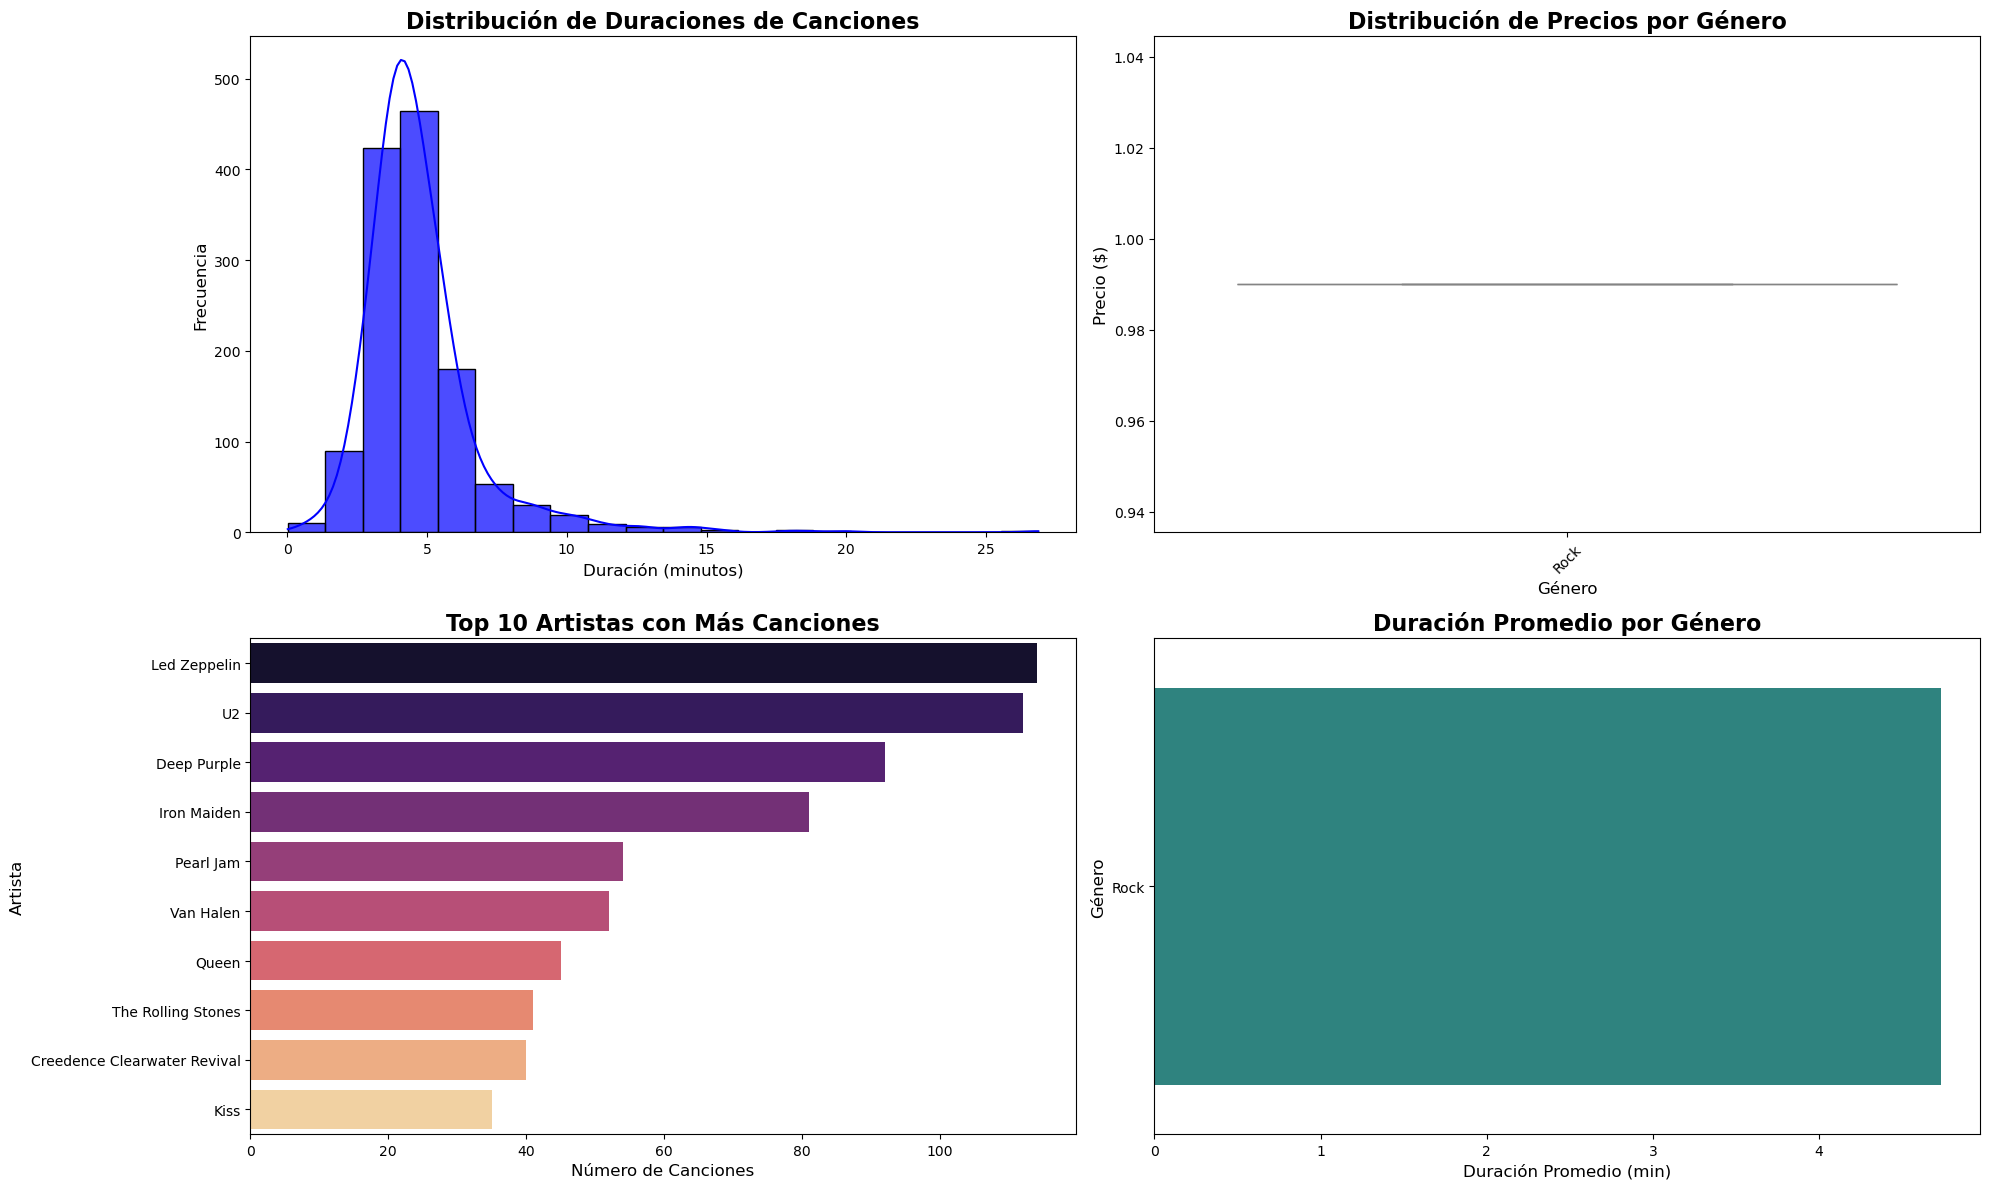


⏳ Reporte de canciones largas (>5 min):

📊 Estadísticas de Canciones:
Total de canciones encontradas: 1069
Duración promedio: 13.14 minutos
Precio promedio: $1.19

🎵 Top 10 Artistas con más canciones:
Artista
Iron Maiden                       117
Lost                               91
Metallica                          75
Led Zeppelin                       54
The Office                         53
Deep Purple                        46
U2                                 29
Battlestar Galactica (Classic)     24
Heroes                             23
Battlestar Galactica               20
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


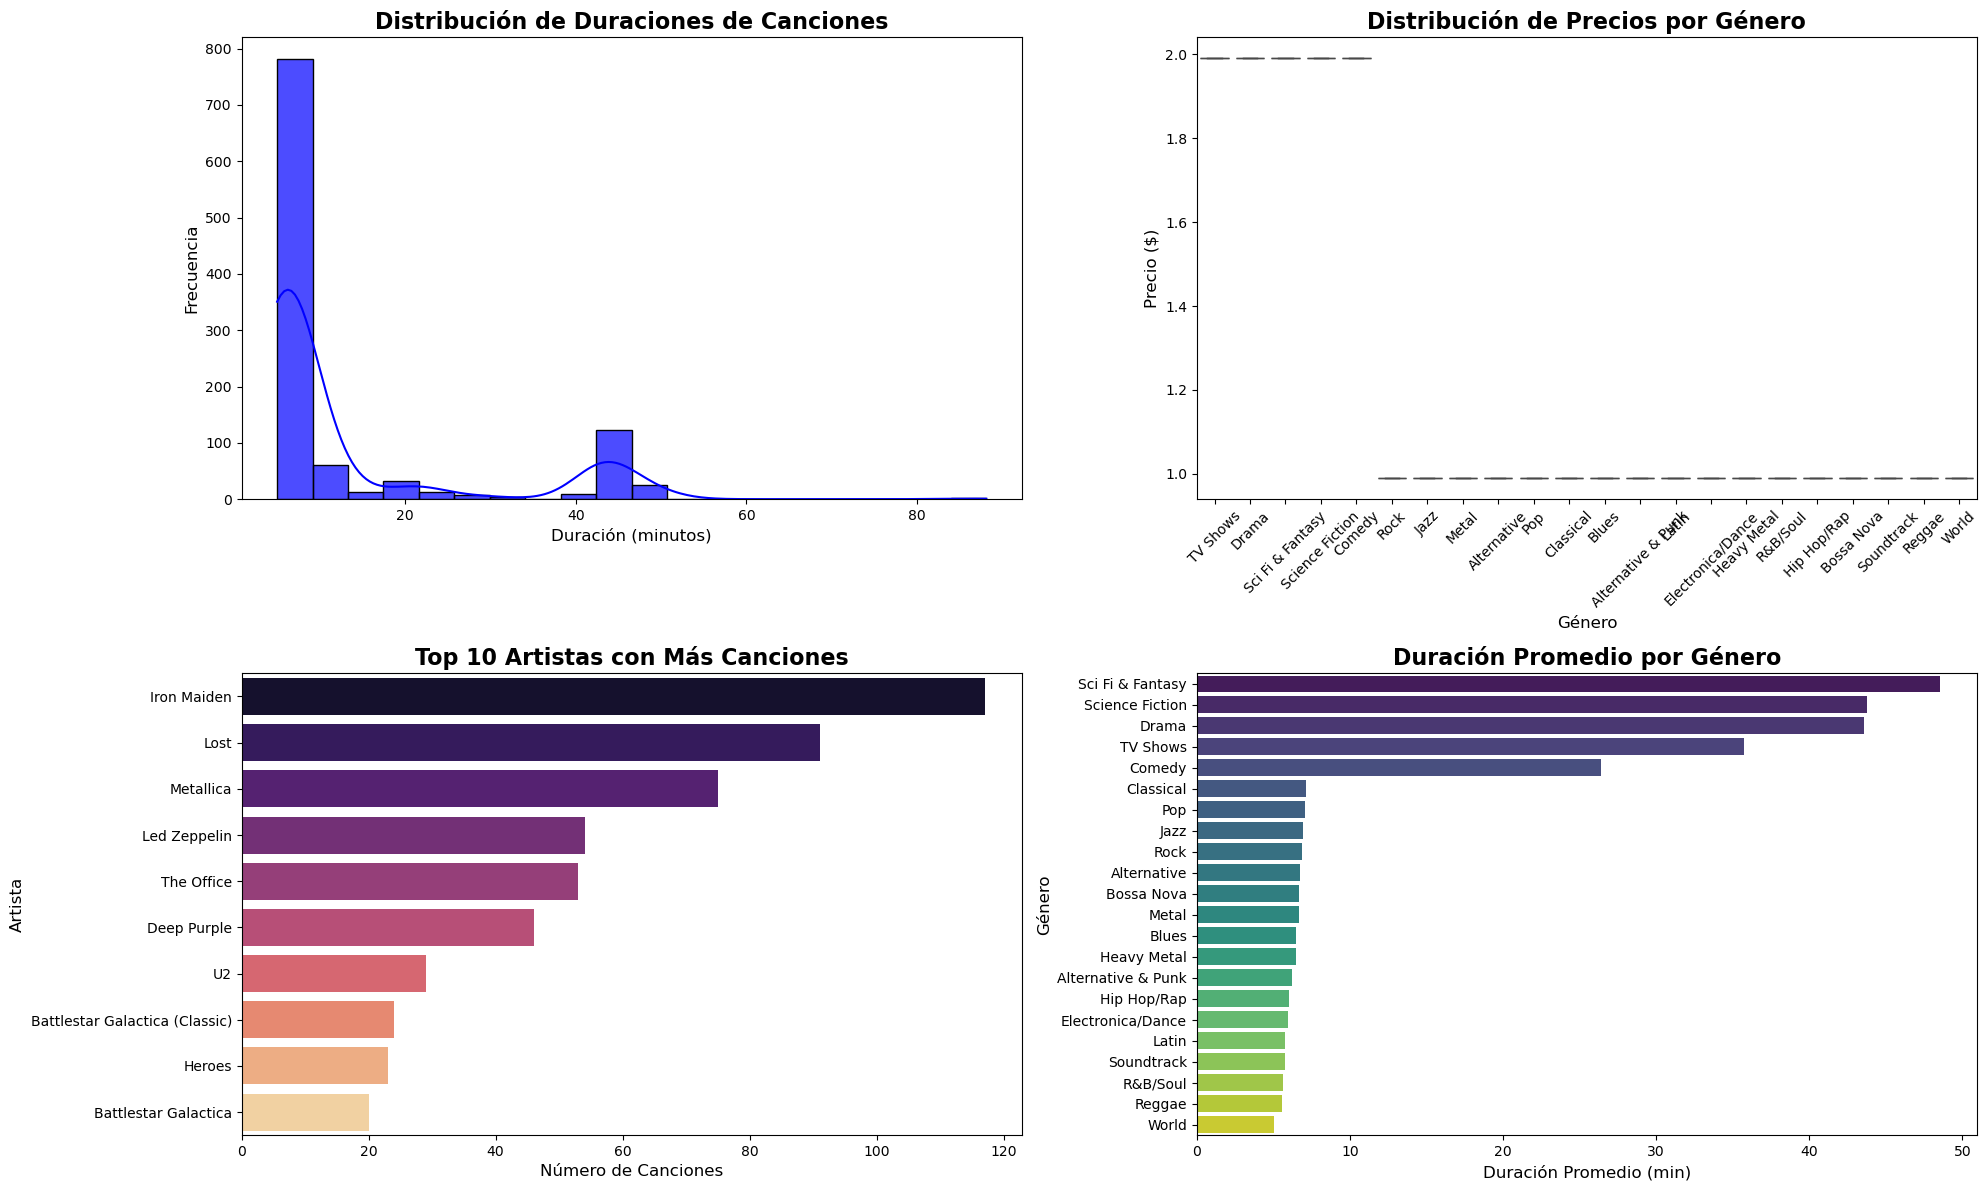


👑 Reporte de canciones de Queen:

📊 Estadísticas de Canciones:
Total de canciones encontradas: 45
Duración promedio: 3.86 minutos
Precio promedio: $0.99

🎵 Top 10 Artistas con más canciones:
Artista
Queen    45
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


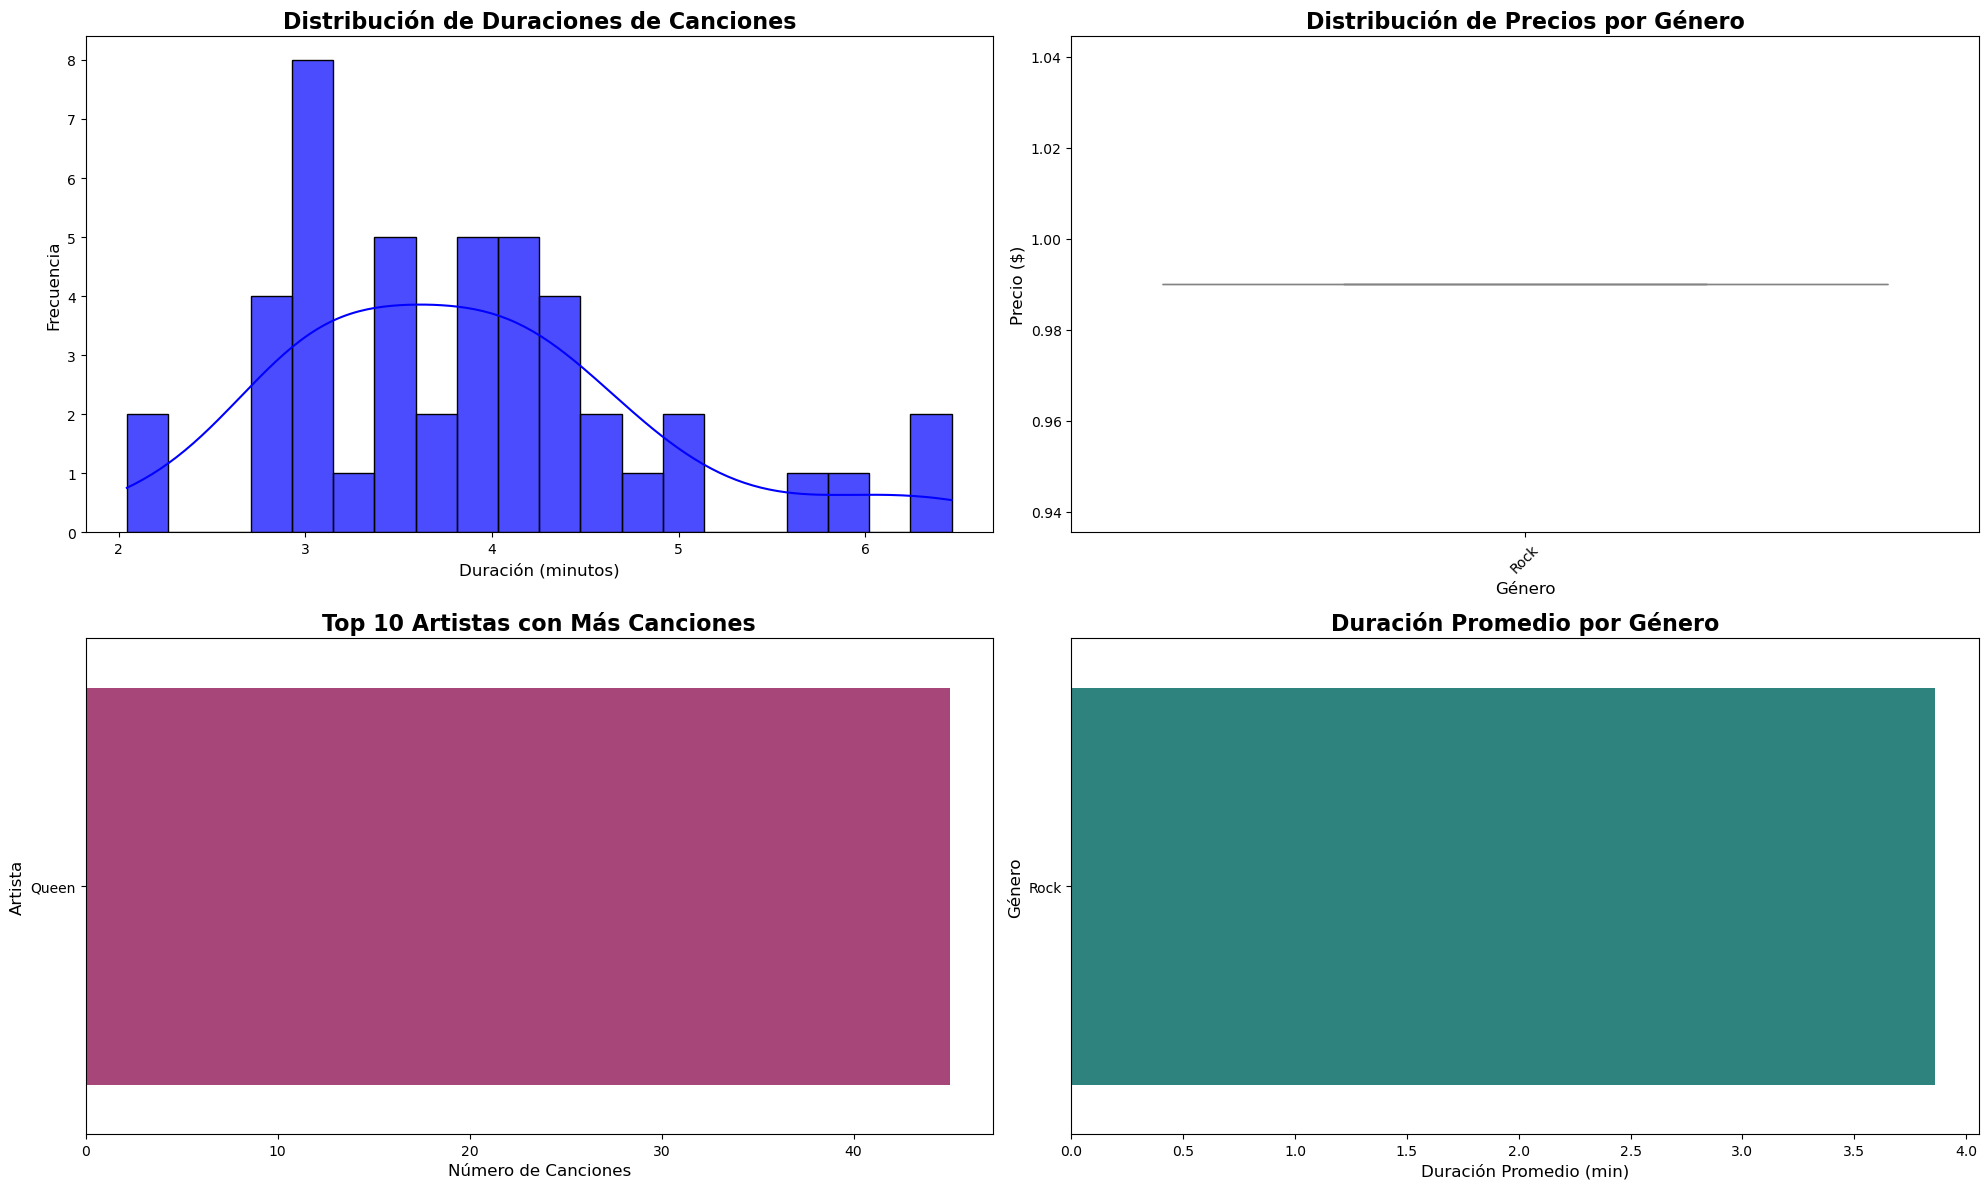


🎶 Reporte de canciones de Rock entre 3 y 5 minutos:

📊 Estadísticas de Canciones:
Total de canciones encontradas: 737
Duración promedio: 4.04 minutos
Precio promedio: $0.99

🎵 Top 10 Artistas con más canciones:
Artista
U2                       76
Led Zeppelin             50
Deep Purple              45
Queen                    34
Pearl Jam                33
Lenny Kravitz            28
Kiss                     25
Van Halen                25
The Cult                 24
Red Hot Chili Peppers    24
Name: count, dtype: int64


/tmp/ipykernel_1135/792524904.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Genero", y="Precio", palette="coolwarm")
/tmp/ipykernel_1135/792524904.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_artistas.index, x=top_artistas.values, palette="magma")
/tmp/ipykernel_1135/792524904.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=mean_duration.index, x=mean_duration.values, palette="viridis")


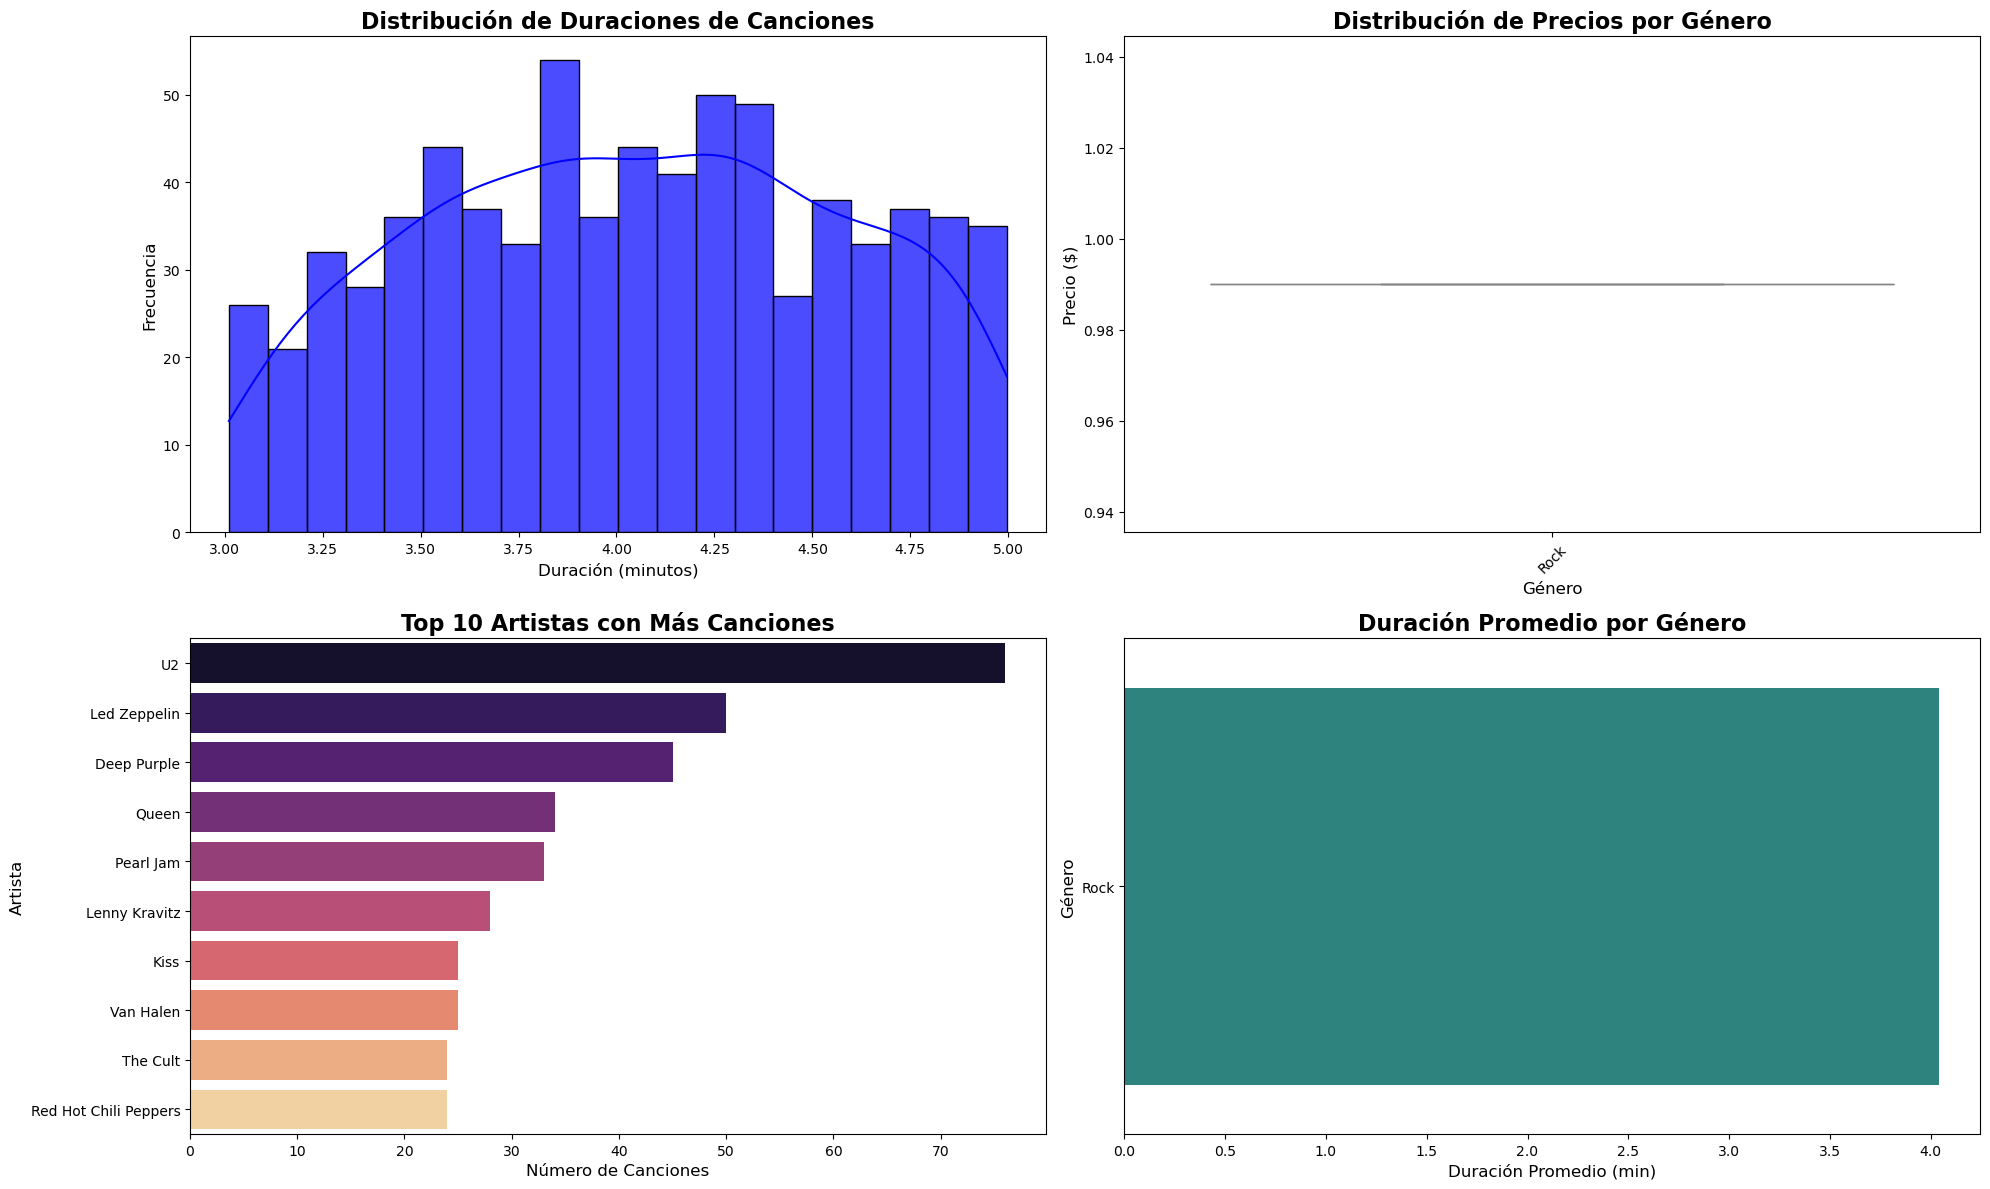

In [14]:
if __name__ == "__main__":
    # 1. Búsqueda de canciones de Rock
    print("\n Reporte de canciones de Rock:")
    df_rock = buscar_canciones(engine, genre="Rock")

    # 2. Búsqueda de canciones largas (más de 5 minutos)
    print("\n Reporte de canciones largas (>5 min):")
    df_largas = buscar_canciones(engine, min_duration=300000)

    # 3. Búsqueda de canciones de Queen
    print("\n Reporte de canciones de Queen:")
    df_queen = buscar_canciones(engine, artist_name="Queen")

    # 4. Reporte de canciones de Rock entre 3 y 5 minutos
    print("\n Reporte de canciones de Rock entre 3 y 5 minutos:")
    df_rock_3_5min = buscar_canciones(engine, genre="Rock", min_duration=180000, max_duration=300000)


## 3. Query Dinámica Análisis de Géneros Musicales

In [15]:
def analizar_generos(engine, min_tracks=None):
    """
    Realiza un análisis de géneros musicales en la base de datos Chinook.

    Parámetros:
        engine: Conexión a la base de datos.
        min_tracks (int): Número mínimo de canciones para filtrar géneros (opcional).

    Retorna:
        DataFrame con los resultados de la consulta.
    """

    # Construcción de la query dinámica
    query = """
    SELECT 
        Genre.Name AS Genero,
        COUNT(Track.TrackId) AS Num_Tracks,
        AVG(Track.Milliseconds) / 60000 AS Duracion_Promedio_Minutos,
        AVG(Track.UnitPrice) AS Precio_Promedio
    FROM Track
    JOIN Genre ON Track.GenreId = Genre.GenreId
    GROUP BY Genre.Name
    HAVING 1=1
    """
    
    params = {}

    if min_tracks:
        query += " AND COUNT(Track.TrackId) >= :min_tracks"
        params["min_tracks"] = min_tracks

    query += " ORDER BY Num_Tracks DESC"

    # Ejecutar la consulta
    df = pd.read_sql(query, engine, params=params)

    # Calcular estadísticas generales
    total_generos = len(df)
    total_tracks = df["Num_Tracks"].sum()
    duracion_promedio = df["Duracion_Promedio_Minutos"].mean()
    precio_promedio = df["Precio_Promedio"].mean()

    # Identificar géneros destacados
    genero_mas_tracks = df.loc[df["Num_Tracks"].idxmax(), "Genero"]
    genero_mayor_duracion = df.loc[df["Duracion_Promedio_Minutos"].idxmax(), "Genero"]
    genero_mayor_precio = df.loc[df["Precio_Promedio"].idxmax(), "Genero"]

    # Imprimir estadísticas generales
    print("\n📊 Estadísticas de Géneros Musicales:")
    print(f"Total de géneros: {total_generos}")
    print(f"Total de canciones: {total_tracks}")
    print(f"Duración promedio general: {duracion_promedio:.2f} minutos")
    print(f"Precio promedio general: ${precio_promedio:.2f}")
    print("\n🏆 Géneros Destacados:")
    print(f"Género con más tracks: {genero_mas_tracks}")
    print(f"Género con mayor duración promedio: {genero_mayor_duracion}")
    print(f"Género con precio promedio más alto: {genero_mayor_precio}")

    # Generar visualizaciones
    generar_visualizaciones_generos(df)

    return df

In [16]:
def generar_visualizaciones_generos(df):
    """
    Genera visualizaciones para el análisis de géneros musicales.

    Parámetros:
        df: DataFrame con el análisis de géneros musicales.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(20, 12))

    # Gráfico 1: Número de canciones por género
    plt.subplot(2, 2, 1)
    top_tracks = df.sort_values("Num_Tracks", ascending=False).head(10)
    sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
    plt.title("Número de Canciones por Género", fontsize=16, fontweight='bold')
    plt.xlabel("Número de Canciones", fontsize=12)
    plt.ylabel("Género", fontsize=12)

    # Gráfico 2: Duración promedio por género
    plt.subplot(2, 2, 2)
    top_duration = df.sort_values("Duracion_Promedio_Minutos", ascending=False).head(10)
    sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
    plt.title("Duración Promedio por Género", fontsize=16, fontweight='bold')
    plt.xlabel("Duración Promedio (min)", fontsize=12)
    plt.ylabel("Género", fontsize=12)

    # Gráfico 3: Precio promedio por género
    plt.subplot(2, 2, 3)
    top_price = df.sort_values("Precio_Promedio", ascending=False).head(10)
    sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")
    plt.title("Precio Promedio por Género", fontsize=16, fontweight='bold')
    plt.xlabel("Precio Promedio ($)", fontsize=12)
    plt.ylabel("Género", fontsize=12)

    # Gráfico 4: Relación entre precio promedio y número de tracks
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df, x="Num_Tracks", y="Precio_Promedio", alpha=0.7, color="green", s=100)
    plt.title("Relación entre Número de Canciones y Precio Promedio", fontsize=16, fontweight='bold')
    plt.xlabel("Número de Canciones", fontsize=12)
    plt.ylabel("Precio Promedio ($)", fontsize=12)

    plt.tight_layout()
    plt.show()

# Explicación del Código - Análisis de Géneros Musicales en la Base de Datos Chinook

## 1. Función `analizar_generos`

### Objetivo
La función `analizar_generos` permite realizar un análisis de los géneros musicales almacenados en la base de datos **Chinook**, obteniendo métricas clave y generando visualizaciones.

### Construcción de la consulta SQL
La consulta selecciona los siguientes campos:
- `Genre.Name` → Nombre del género musical.
- `COUNT(Track.TrackId)` → Número total de canciones por género.
- `AVG(Track.Milliseconds) / 60000` → Duración promedio de las canciones por género (convertida a minutos).
- `AVG(Track.UnitPrice)` → Precio promedio de las canciones en cada género.

Para extraer esta información, se realiza una unión (`JOIN`) entre las tablas:
- `Track` para obtener los detalles de las canciones.
- `Genre` para obtener el género de cada canción.

Los datos se agrupan por `Genre.Name` para calcular los valores agregados.

---

## 2. Incorporación de Filtros Dinámicos

La función permite filtrar los géneros según un umbral mínimo de canciones (`min_tracks`).

| Filtro        | Descripción |
|--------------|------------|
| `min_tracks` | Excluye géneros que tengan menos canciones que el valor especificado. |

Si el usuario define un valor para `min_tracks`, el filtro se aplica en la consulta SQL para restringir los resultados.

---

## 3. Ejecución de la Consulta y Transformación de Datos

- Se ejecuta la consulta usando `pd.read_sql`, obteniendo un **DataFrame de Pandas** con los resultados.
- La duración promedio de las canciones se convierte de **milisegundos a minutos**, facilitando su interpretación.

---

## 4. Cálculo de Estadísticas

Después de obtener los datos, se calculan métricas clave para analizar la distribución de géneros musicales:

### Estadísticas Generales
- **Número total de géneros musicales** en la base de datos.
- **Número total de canciones** en todos los géneros.
- **Duración promedio general** de las canciones.
- **Precio promedio general** de las canciones.

### Géneros Destacados
Se identifican los géneros con valores extremos en diferentes categorías:
- **Género con más canciones**.
- **Género con la mayor duración promedio**.
- **Género con el precio promedio más alto**.

Estos datos ayudan a comprender cómo varían las características musicales en la base de datos.

---

## 5. Generación de Visualizaciones

Se generan cuatro gráficos para analizar los resultados obtenidos:

1. **Número de canciones por género**  
   - Se usa un gráfico de barras para mostrar los géneros con más canciones.

2. **Duración promedio por género**  
   - Permite comparar la duración promedio de las canciones entre diferentes géneros.

3. **Precio promedio por género**  
   - Representa los géneros con canciones más caras en promedio.

4. **Relación entre número de canciones y precio promedio**  
   - Se utiliza un gráfico de dispersión para visualizar si existe una relación entre el número de canciones de un género y su precio promedio.

Estas visualizaciones facilitan la interpretación de los datos y permiten identificar patrones en la base de datos.

---

## 6. Ejecución del Código en `if __name__ == "__main__"`

El código se ejecuta en cuatro escenarios distintos para realizar diferentes tipos de análisis:

1. **Análisis de géneros por número de canciones**  
2. **Análisis de géneros por duración promedio**  
3. **Análisis de géneros por precio promedio**  
4. **Análisis de géneros con al menos 100 canciones**  

Cada consulta genera:
- Un resumen estadístico en consola.
- Visualizaciones para representar los datos de manera gráfica.

---

## Conclusión

El código permite analizar la distribución de los géneros musicales en la base de datos **Chinook**, proporcionando información detallada sobre el número de canciones, duración y precios.

Este análisis es útil para:
- Comparar la cantidad de canciones en cada género.
- Identificar tendencias en la duración promedio de los géneros.
- Evaluar la relación entre el número de canciones y los precios promedio.

El código es modular y escalable, lo que permite adaptarlo fácilmente a nuevos criterios de análisis sin modificar su estructura principal.



 Reporte de géneros por número de tracks:

📊 Estadísticas de Géneros Musicales:
Total de géneros: 25
Total de canciones: 3503
Duración promedio general: 11.12 minutos
Precio promedio general: $1.19

🏆 Géneros Destacados:
Género con más tracks: Rock
Género con mayor duración promedio: Sci Fi & Fantasy
Género con precio promedio más alto: TV Shows


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


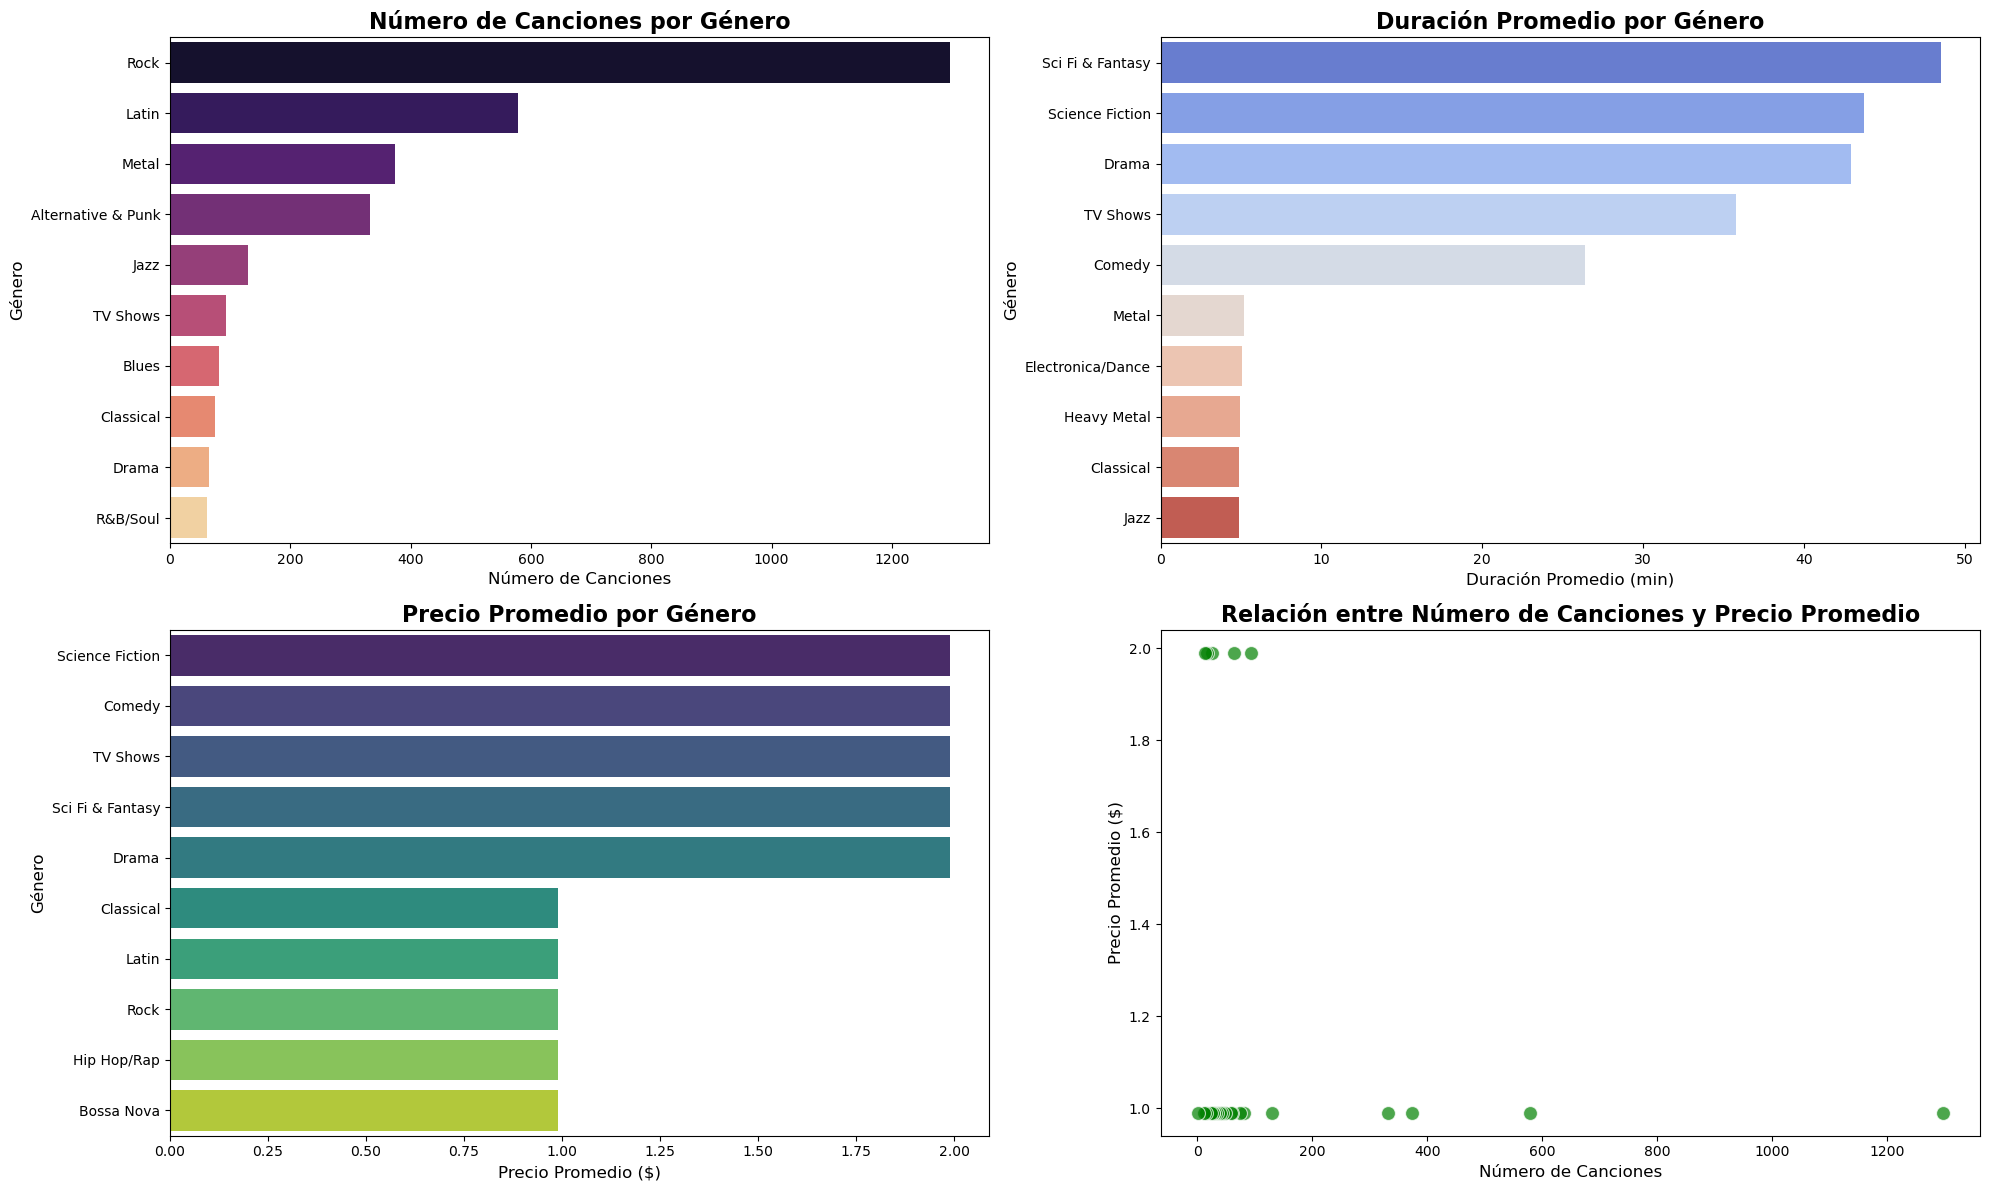


 Reporte de géneros por duración promedio:

📊 Estadísticas de Géneros Musicales:
Total de géneros: 25
Total de canciones: 3503
Duración promedio general: 11.12 minutos
Precio promedio general: $1.19

🏆 Géneros Destacados:
Género con más tracks: Rock
Género con mayor duración promedio: Sci Fi & Fantasy
Género con precio promedio más alto: TV Shows


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


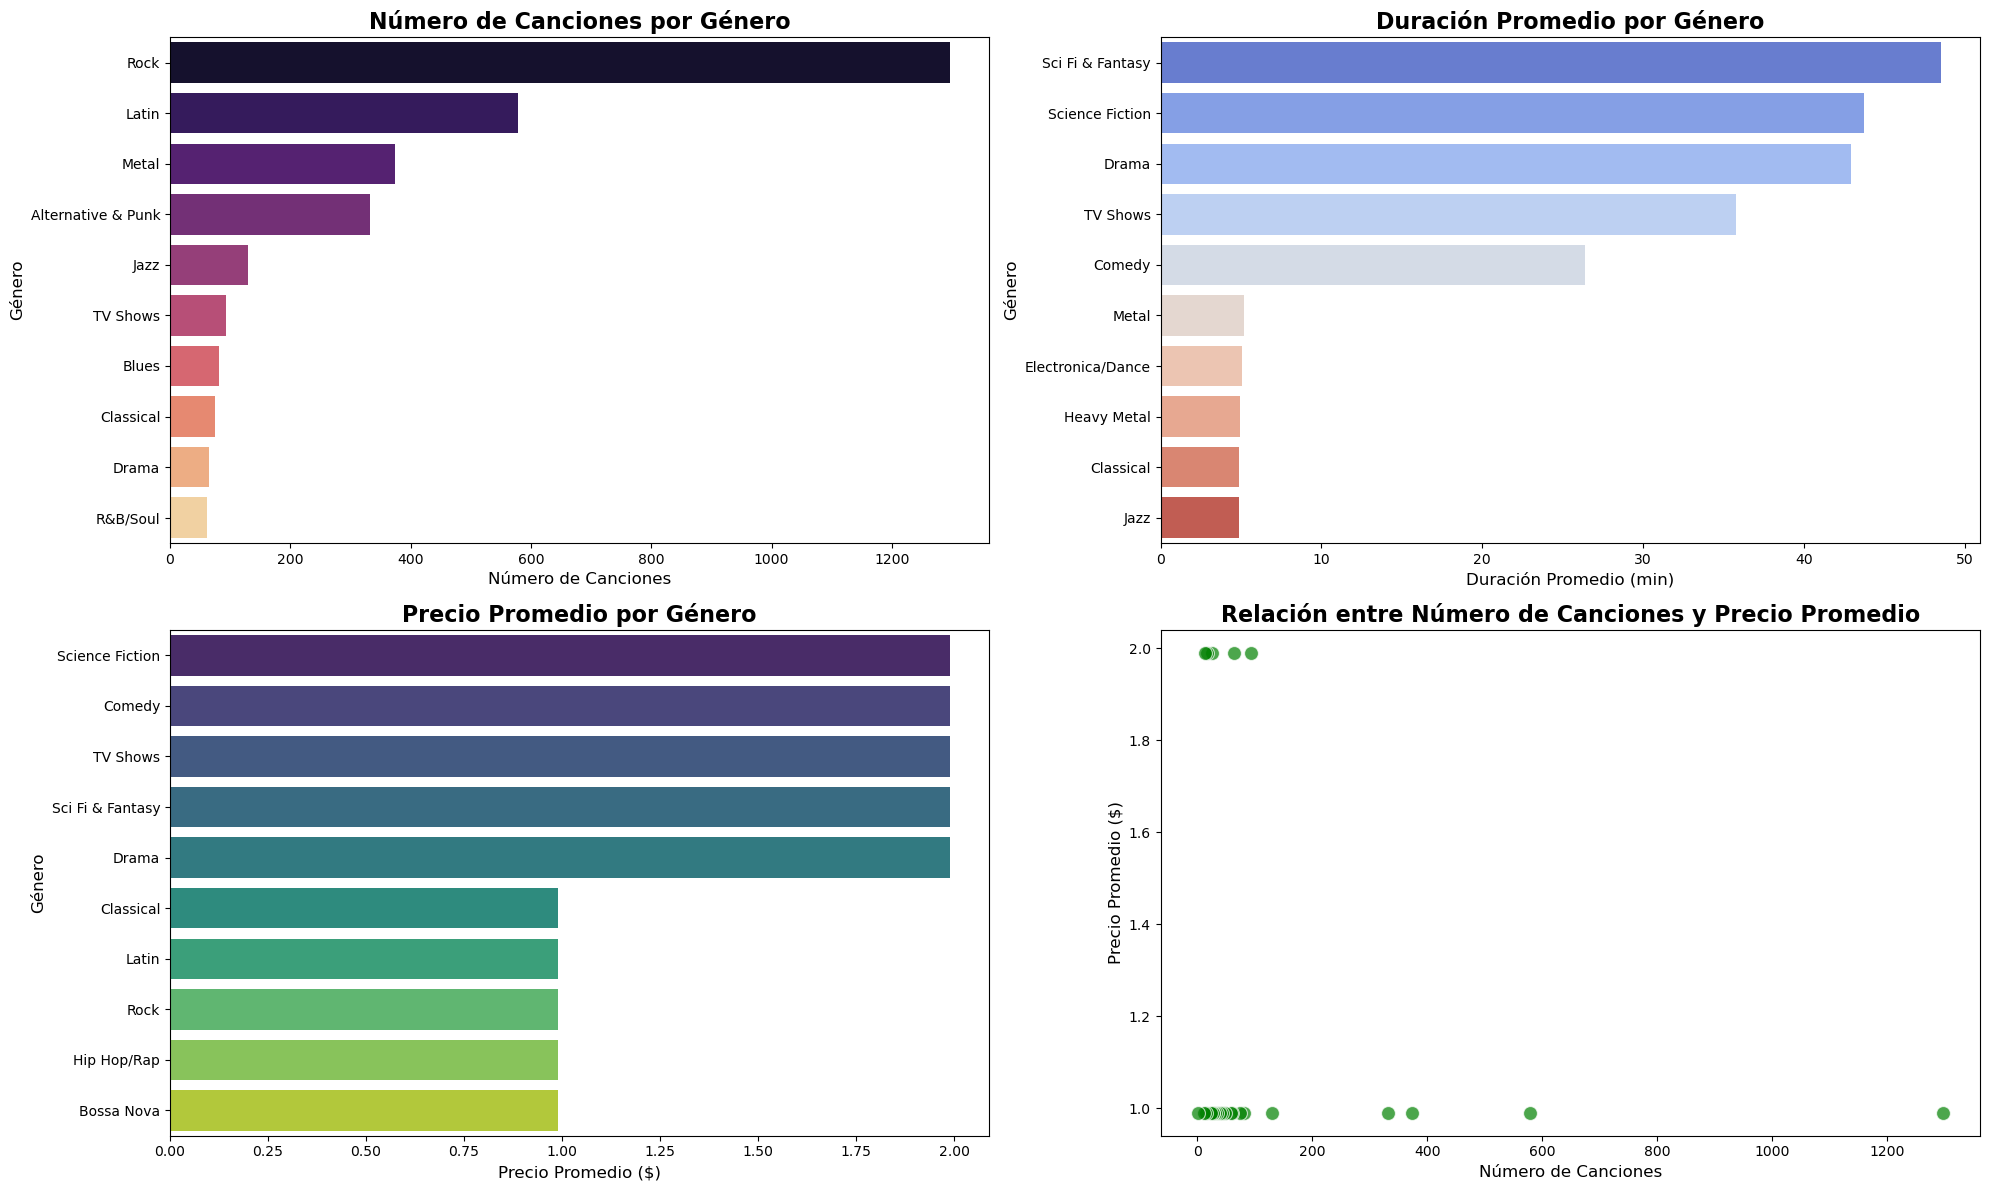


 Reporte de géneros por precio promedio:

📊 Estadísticas de Géneros Musicales:
Total de géneros: 25
Total de canciones: 3503
Duración promedio general: 11.12 minutos
Precio promedio general: $1.19

🏆 Géneros Destacados:
Género con más tracks: Rock
Género con mayor duración promedio: Sci Fi & Fantasy
Género con precio promedio más alto: TV Shows


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


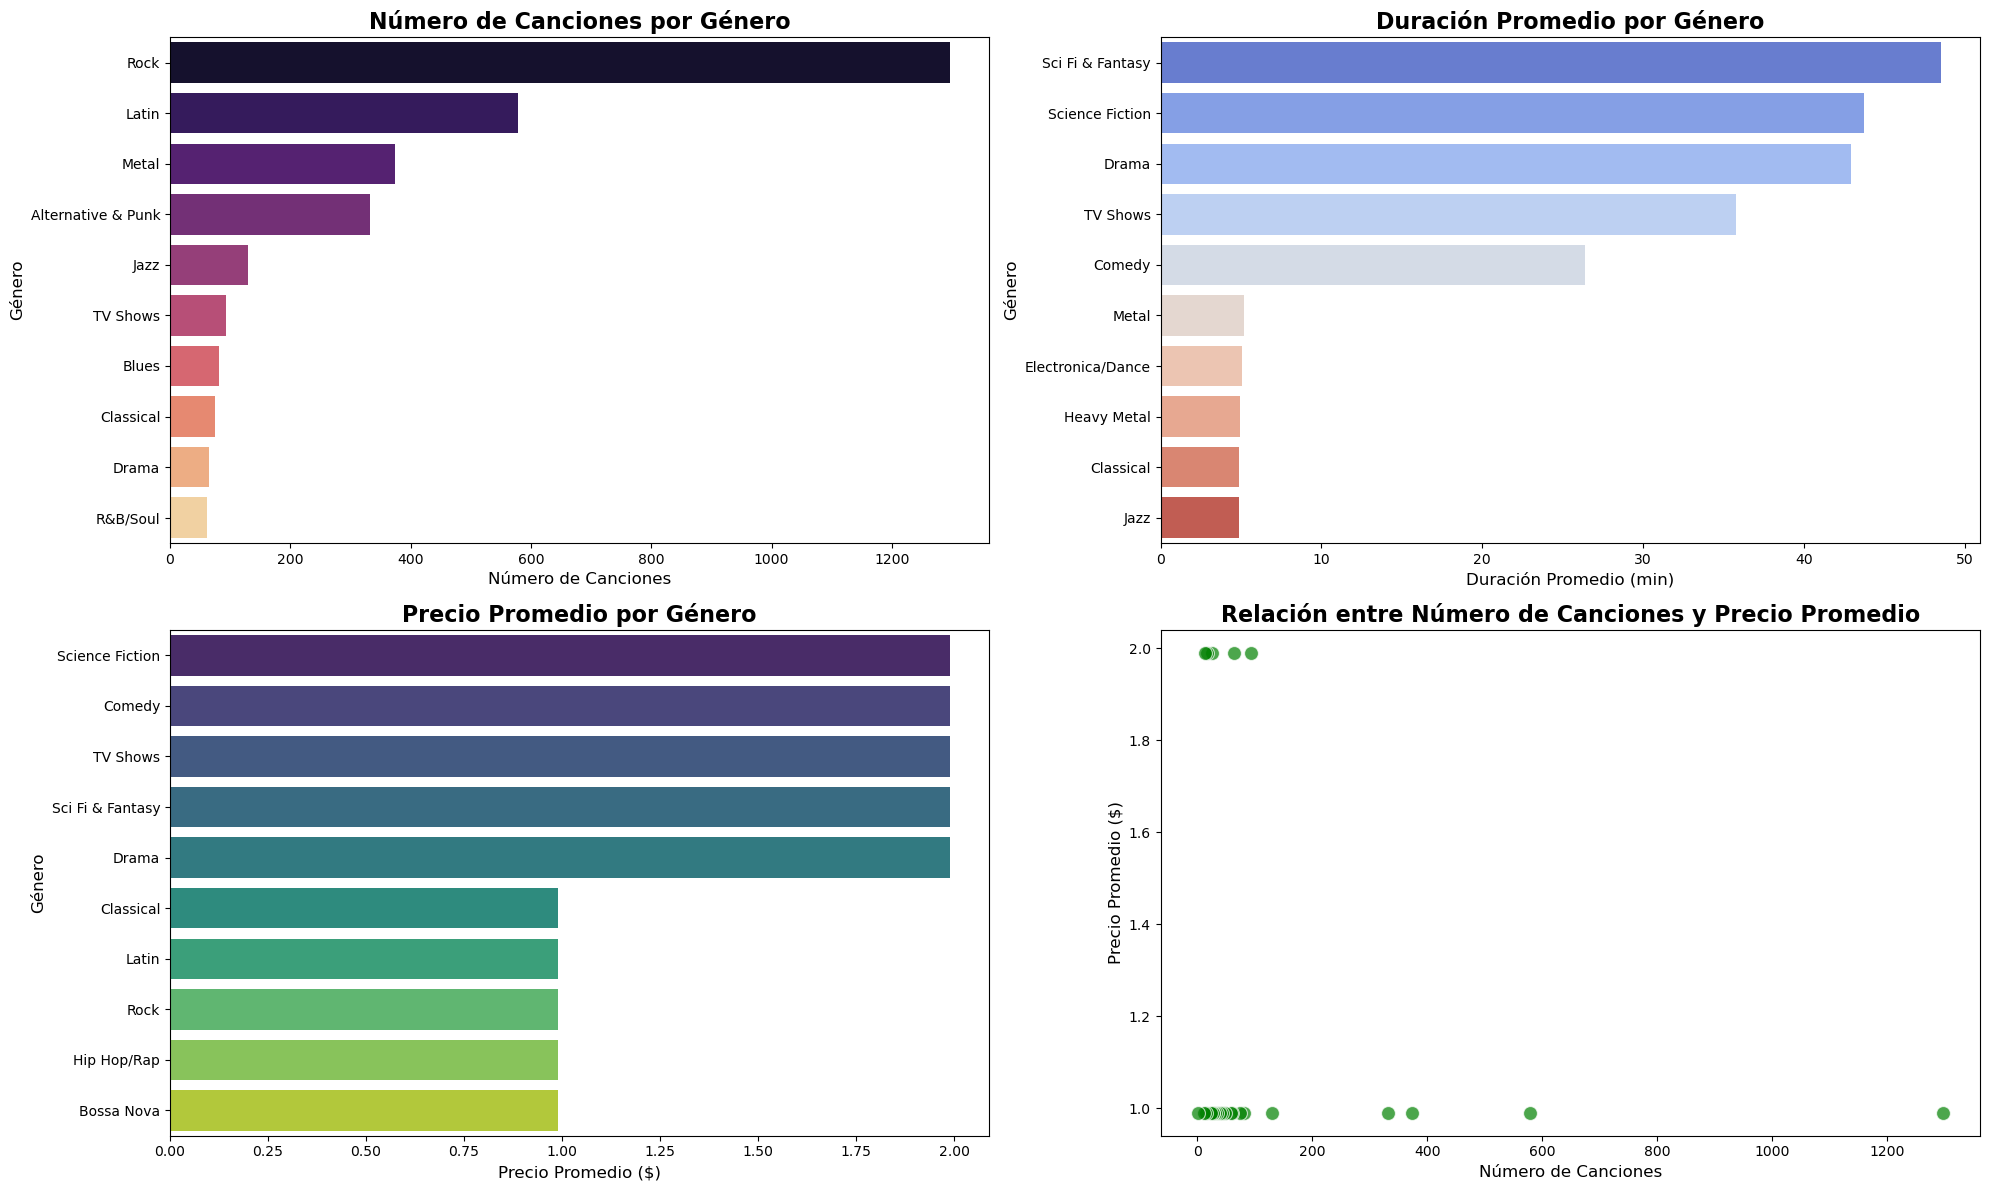


 Reporte de géneros con al menos 100 tracks:

📊 Estadísticas de Géneros Musicales:
Total de géneros: 5
Total de canciones: 2712
Duración promedio general: 4.51 minutos
Precio promedio general: $0.99

🏆 Géneros Destacados:
Género con más tracks: Rock
Género con mayor duración promedio: Metal
Género con precio promedio más alto: Latin


/tmp/ipykernel_1135/552806253.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_tracks["Genero"], x=top_tracks["Num_Tracks"], palette="magma")
/tmp/ipykernel_1135/552806253.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_duration["Genero"], x=top_duration["Duracion_Promedio_Minutos"], palette="coolwarm")
/tmp/ipykernel_1135/552806253.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_price["Genero"], x=top_price["Precio_Promedio"], palette="viridis")


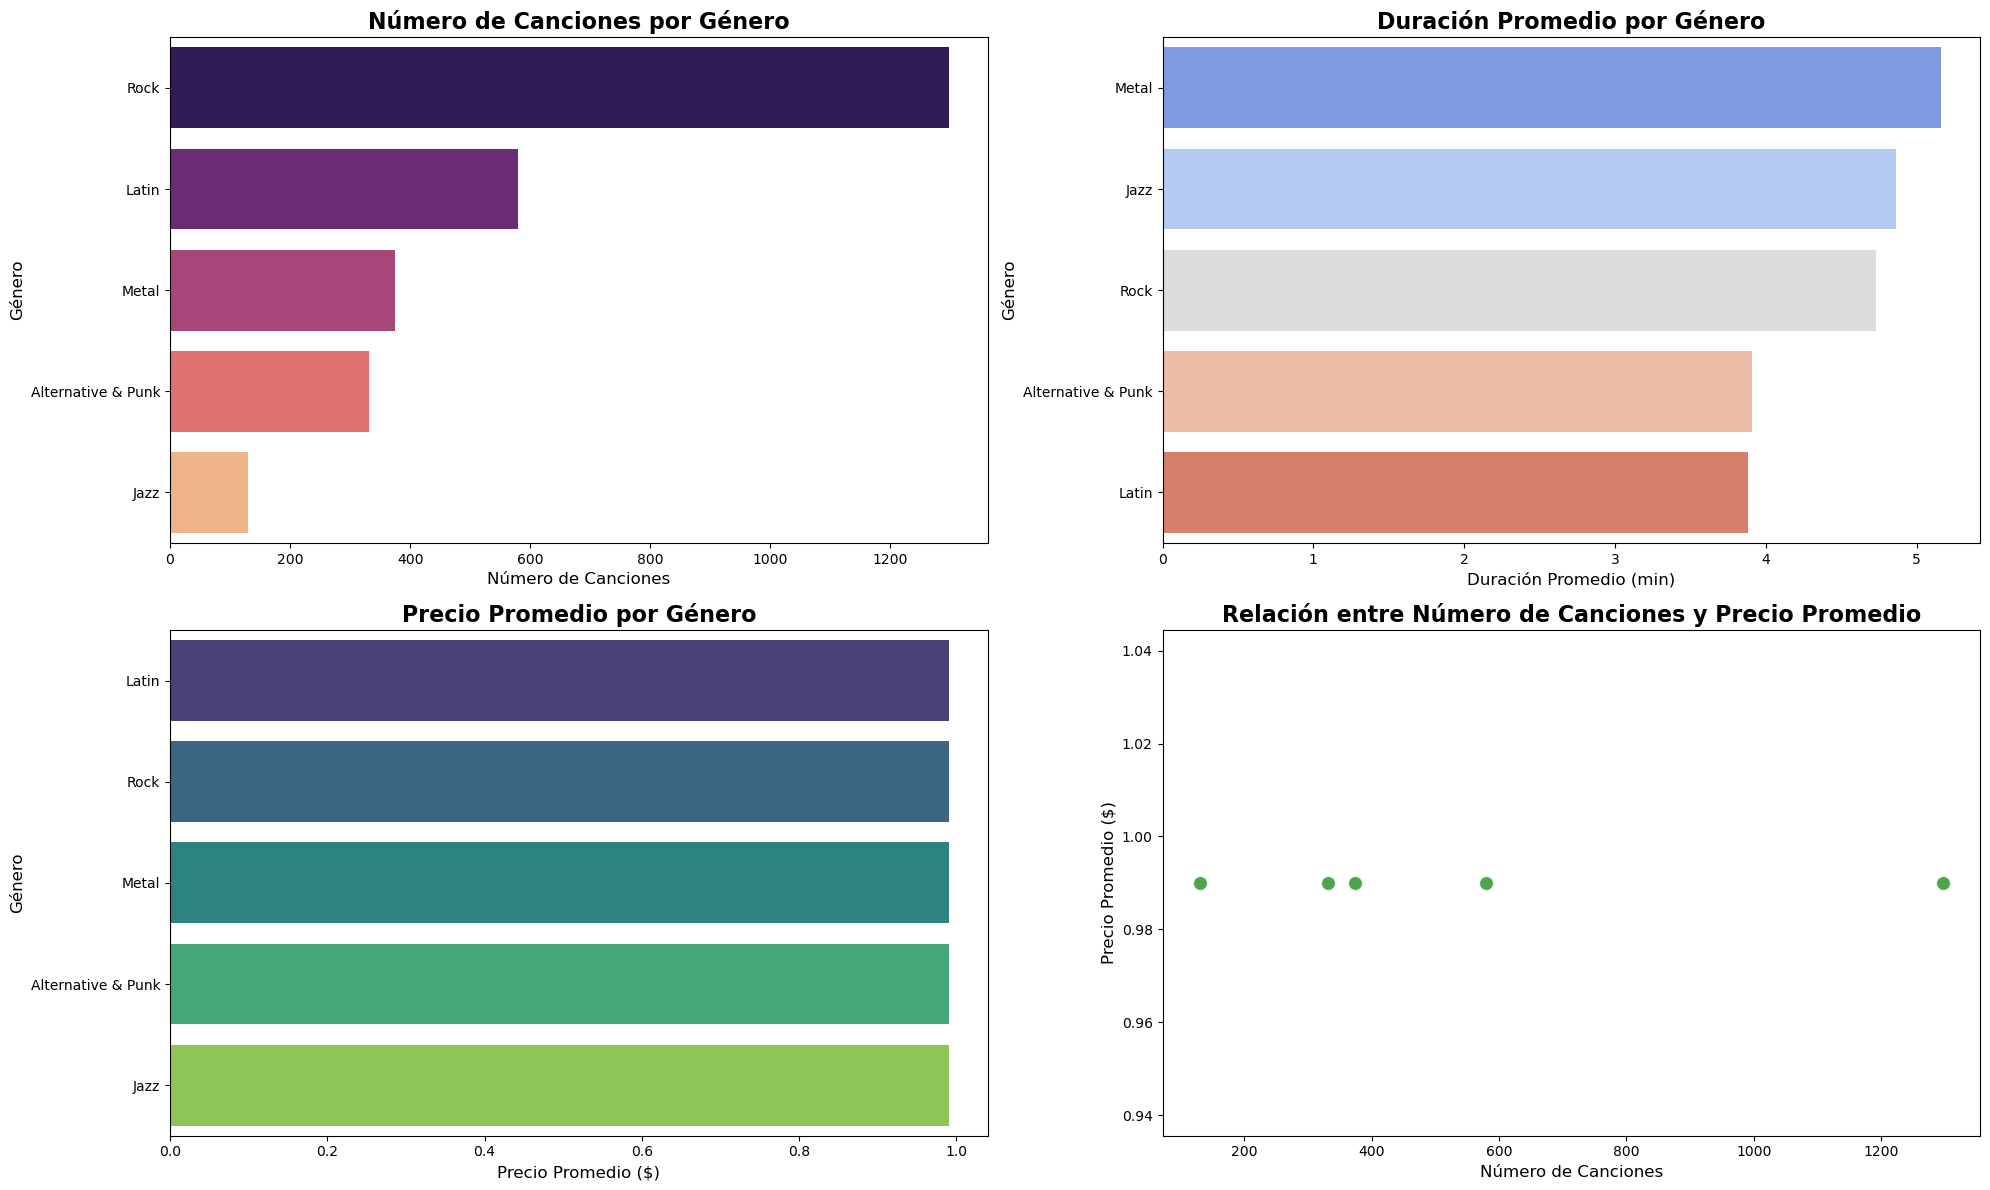

In [18]:
if __name__ == "__main__":
    # 1. Análisis de géneros por número de tracks
    print("\n Reporte de géneros por número de tracks:")
    df_generos_tracks = analizar_generos(engine)

    # 2. Análisis de géneros por duración promedio
    print("\n Reporte de géneros por duración promedio:")
    df_generos_duracion = analizar_generos(engine)

    # 3. Análisis de géneros por precio promedio
    print("\n Reporte de géneros por precio promedio:")
    df_generos_precio = analizar_generos(engine)

    # 4. Análisis de géneros con al menos 100 tracks
    print("\n Reporte de géneros con al menos 100 tracks:")
    df_generos_min100 = analizar_generos(engine, min_tracks=100)